# A Simple Computational Model of Information Propagation in 2D Lattice Space


## Table of Contents
1. Introduction
2. Defining Node and Grid objects
3. Sample trials
4. Plotting the average evolution
5. Comparing equilibration patterns of different initial conditions and probabilities
6. Other definitions of time
7. Discussion and Conclusion
8. References

## 1. Introduction

In the digital era, we are always bombarded with all kinds of information, a large portion of which is false. Therefore, the propagation of information and misinformation among populations of individuals is of substantial interest. Some classical models include the SIR model (susceptible-infected-recovered) of infectious diseases from epidemiology, which is solved by coupled differential equations and applies to knowledge of information and misinformation as well. <br>
Here, I propose a simple computational model of propagation of information in 2D rectangular lattice space with periodic boundary conditions, based on concepts of emergent, probabilistic behavior inspired by the 2D Ising model: individual particles in the lattice can serve as discrete nodes of propagation, and states of particles can serve as the status of each particular individual's knowledge of news.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng

### Definitions

News: a global event that may be represented truthfully or falsely by different individuals <br>
Information: a particular type of state of any local individual’s knowledge of news <br>
Space: 𝑁×𝑀 2D rectangular lattice with periodic boundary conditions (mainly 10×10 and 50×50) <br>
Time: 1 unit of time = N*M trials <br>
Source(s): any node that is not neutral at 𝑡=0 <br>
Propagation: the process by which neutral nodes become non-neutral (or single-informed nodes become multi-informed) based on neighboring node states (local / wide) <br>
Contact / exposure to information: contact between any two neighboring nodes is probabilistic, but once a neutral node is in contact with another non-neutral node, it guarantees transmission and knowledge of that information: P(information) = P(exposure) = P <br>
Age factor: based on the SIR model, nodes no longer spread information after $a$ stable units (being in the same state for $a$ units of time, which is reset once they change to a different state)

For each individual involved in the propogation of information regarding a particular news event, I have defined the following 4 standard possible states in this `state_map` dictionary. For the value of each key, [0] is the corresponding numerical value (not of much use yet), [1] explains the state in string, [2] is the age factor of the state, and [3] is the color by which I represent each of the states in graphs.

In [5]:
state_map = {'t': [1, 'correctly informed', 5, 'g'],
             'f': [-1, 'misinformed', 5, 'r'],
             'n': [0, 'uninformed', 0, 'b'],
             'm': [0, 'multi-informed', 2, 'y']}

## 2. Defining Node and Grid objects

A Node object is a discrete, individual point in a 2D rectangular lattice that can change state; a Grid object is the 2D array of all Node objects in a rectangluar lattice with fixed node configuration.

In [21]:
class Node():
    
    """
    Constructor function:
        (self.i, self.j) ([int], [int]): the coordinate in the corresponding grid
        self.state [str]: the state of the node, a key in the state_map dictionary
        self.value [int]: a numerical value implied by the state, not yet of great use in this project yet
        self.age [int]: 
    """
    def __init__(self, i, j, state):
        self.i = i
        self.j = j
        self.state = state
        self.value = state_map[self.state][0]
        self.age = 0

    def change_state(self, new_state, grid=None):
        self.state = new_state
        self.value = state_map[new_state][0]
        self.age = 0
        if grid != None:
            grid.change_node(self.i, self.j, self)

    def add_age(self):
        self.age = self.age + 1

    def active(self, free=False):
        age = state_map[self.state][2]
        if free or self.age < age:
            return 'a'
        else:
            return 'i'

    # returns a list of states of the 4 immediate neighbors of the node
    def first_neighbors(self, grid, age=False):
        above = self.i - 1
        below = self.i + 1 - grid.N
        left = self.j - 1
        right = self.j + 1 - grid.M
        above_state = grid.states[above][self.j] + grid.config[above][self.j].active(age)
        below_state = grid.states[below][self.j] + grid.config[below][self.j].active(age)
        left_state = grid.states[self.i][left] + grid.config[self.i][left].active(age)
        right_state = grid.states[self.i][right] + grid.config[self.i][right].active(age)

        states = [above_state, below_state, left_state, right_state]
        return states

    # computes the distance squared between the node and another coordinate in the grid
    def distance_sqr(self, grid, i, j):
        horizontal = min(abs(self.i-i), grid.N-abs(self.i-i))
        vertical = min(abs(self.j-j), grid.M-abs(self.j-j))
        distance_square = horizontal**2 + vertical**2
        return distance_square

    # determines whether and how the node changes state based on only its 4 immediate neighbors (with real-time update)
    def multi_informed(self, grid, p=0.5, age=False):
        neighbor_states = self.first_neighbors(grid, age)
        ta = neighbor_states.count('ta')
        fa = neighbor_states.count('fa')
        ma = neighbor_states.count('ma')
        pt = (1-(1-p)**ta) * (1-p)**(fa+ma)
        pf = (1-(1-p)**fa) * (1-p)**(ta+ma)
        pn = (1-p)**(ta+fa+ma)
        pm = 1 - pt - pf - pn
        chance = rng.random()
        inform = chance < pt
        misinform = chance >= pt and chance < pt + pf
        multiinform = chance >= 1 - pm
        # print(chance, pt, pf, pn, pm)
        if inform and self.state == 'n':
            self.change_state('t', grid)
        elif misinform and self.state == 'n':
            self.change_state('f', grid)
        elif multiinform and self.state != 'm':
            self.change_state('m', grid)
        else:
            self.add_age()

    # determines whether and how the node changes state based on only its 4 immediate neighbors (stored and delayed update)
    def timed_multi_informed(self, grid, p=0.5, age=False):
        neighbor_states = self.first_neighbors(grid, age)
        ta = neighbor_states.count('ta')
        fa = neighbor_states.count('fa')
        ma = neighbor_states.count('ma')
        pt = (1-(1-p)**ta) * (1-p)**(fa+ma)
        pf = (1-(1-p)**fa) * (1-p)**(ta+ma)
        pn = (1-p)**(ta+fa+ma)
        pm = 1 - pt - pf - pn
        chance = rng.random()
        inform = chance < pt
        misinform = chance >= pt and chance < pt + pf
        multiinform = chance >= 1 - pm
        # print(chance, pt, pf, pn, pm)
        if inform and self.state == 'n':
            return 't', True
        elif misinform and self.state == 'n':
            return 'f', True
        elif multiinform and self.state != 'm':
            return 'm', True
        else:
            return 'n', False

    # determines whether and how the node changes state based on all nodes (practically nodes within 10 units of length) with a factor of 
    # distance ** (-2) (stored and delayed update)
    def timed_widely_multi_informed(self, grid, p=0.5, age=False):
        order = fixed_order(grid.N, grid.M)
        order.remove((self.i, self.j))
        ta = 0
        fa = 0
        ma = 0
        for point in order:
            distance_square = self.distance_sqr(grid, point[0], point[1])
            node = grid.config[point[0]][point[1]]
            if distance_square <= 100 and node.active(age) == 'a':
                if node.state == 't':
                    ta += 1/distance_square
                elif node.state == 'f':
                    fa += 1/distance_square
                elif node.state == 'm':
                    ma += 1/distance_square
        pt = (1-(1-p)**ta) * (1-p)**(fa+ma)
        pf = (1-(1-p)**fa) * (1-p)**(ta+ma)
        pn = (1-p)**(ta+fa+ma)
        pm = 1 - pt - pf - pn
        chance = rng.random()
        inform = chance < pt
        misinform = chance >= pt and chance < pt + pf
        multiinform = chance >= 1 - pm
        # print(chance, pt, pf, pn, pm)
        if inform and self.state == 'n':
            return 't', True
        elif misinform and self.state == 'n':
            return 'f', True
        elif multiinform and self.state != 'm':
            return 'm', True
        else:
            return 'n', False

In [27]:
def random_spot(N, M):
    i = rng.randint(0, N)
    j = rng.randint(0, M)
    random_point = np.array([i, j])
    return random_point

In [29]:
def random_order(N, M):
    length = list(range(N*M))
    rng.shuffle(length)
    # print(length)
    for i,x in enumerate(length):
        length[i] = (x//M, x%M)
    return length

In [31]:
def fixed_order(N, M):
    length = list(range(N*M))
    for i,x in enumerate(length):
        length[i] = (x//M, x%M)
    return length

In [97]:
class Grid():

    """
    Constructor function:
        (self.N, self.M) ([int], [int]): the length and width of the 2D rectangular lattice with periodic boundary conditions
        self.name [str]: the name of the grid
        self.config [list]: the 2D array of all the Node objects in this grid
        self.states [list]: the 2D array of the states of all the Node objects in this grid
        self.array [list]: the 2D array of the numerical values of all the Node objects in this grid
    """
    def __init__(self, N, M, name='MyGrid'):
        self.N = N
        self.M = M
        self.name = name
        config = []
        states = []
        for row in range(N):
            config.append([])
            states.append([])
            for node in range(M):
                config[row].append(Node(row, node, 'n'))
                states[row].append('n')
        self.config = config
        self.states = states
        self.array = np.zeros([N, M])
        
    def change_node(self, i, j, node):
        self.config[i][j] = node
        self.states[i][j] = node.state
        self.array[i][j] = node.value

    def count_cells(self, state):
        total = 0
        for row in self.states:
            total += row.count(state)
        return total

    
    # [NOT USED] Simulates and plots the propagation based on a free definition of time: each trial is done on a completely randomly selected
    # node with real-time update.
    def free_multi_spread_graph(self, times, p=0.5, age=False, graph=True):
        infos = np.array([self.count_cells('t')])
        misinfos = np.array([self.count_cells('f')])
        neutrals = np.array([self.count_cells('n')])
        multis = np.array([self.count_cells('m')])
        equilibrium = 0
        for time in range(times):
            for i in range(self.N * self.M):
                point = random_spot(self.N, self.M)
                # print(point)
                node = self.config[point[0]][point[1]]
                node.multi_informed(self, p, age)
            infos = np.append(infos, self.count_cells('t'))
            misinfos = np.append(misinfos, self.count_cells('f'))
            neutrals = np.append(neutrals, self.count_cells('n'))
            multis = np.append(multis, self.count_cells('m'))

            if time >= 5 and infos[time+1] == infos[time-4] and misinfos[time+1] == misinfos[time-4] and neutrals[time+1] == neutrals[time-4]:
                if infos[time-3] == infos[time-4] and misinfos[time-3] == misinfos[time-4] and neutrals[time-3] == neutrals[time-4]:
                    equilibrium = time - 4
                    break
        
        # equilibrium = 0
        # for time in range(times):
        #     if infos[time] == infos[time+1] and misinfos[time] == misinfos[time+1] and neutrals[time] == neutrals[time+1]:
        #         if infos[time] == infos[-1] and misinfos[time] == misinfos[-1] and neutrals[time] == neutrals[-1]:
        #             equilibrium = time
        #             break
        
        if graph:
            fig, ax = plt.subplots()
            n = np.arange(time+2)
            ax.plot(n,infos,label= 'Evolution of information',color='g')
            ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
            ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
            ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
            ax.scatter(n,infos,color="g")
            ax.scatter(n,misinfos,color="r")
            ax.scatter(n,neutrals,color='b')
            ax.scatter(n,multis,color='y')
            ax.set_title("Free local spread of information in a(n) $" + str(self.N) + " * " + str(self.M) + "$ matrix")
            ax.set_ylabel('Number of nodes')
            ax.set_xlabel('Unit of time (' + str(self.N*self.M) + ' trials per unit)')

            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            plt.show()

        return self, infos, misinfos, neutrals, multis, equilibrium

    
    # [NOT USED] Simulates and plots the propagation based on a more nuanced definition of time: each unit of time ensures one and only one
    # trial on every node, but at a different random order, with changes updated real-time.
    def multi_spread_graph(self, times, p=0.5, age=False, graph=True):
        infos = np.array([self.count_cells('t')])
        misinfos = np.array([self.count_cells('f')])
        neutrals = np.array([self.count_cells('n')])
        multis = np.array([self.count_cells('m')])
        equilibrium = 0
        for time in range(times):
            order = random_order(self.N, self.M)
            for point in order:
                node = self.config[point[0]][point[1]]
                node.multi_informed(self, p, age)
            infos = np.append(infos, self.count_cells('t'))
            misinfos = np.append(misinfos, self.count_cells('f'))
            neutrals = np.append(neutrals, self.count_cells('n'))
            multis = np.append(multis, self.count_cells('m'))
            
            if time >= 5 and infos[time+1] == infos[time-4] and misinfos[time+1] == misinfos[time-4] and neutrals[time+1] == neutrals[time-4]:
                if infos[time-3] == infos[time-4] and misinfos[time-3] == misinfos[time-4] and neutrals[time-3] == neutrals[time-4]:
                    equilibrium = time - 4
                    break
                    
        # equilibrium = 0
        # for time in range(times):
        #     if infos[time] == infos[time+1] and misinfos[time] == misinfos[time+1] and neutrals[time] == neutrals[time+1]:
        #         if infos[time] == infos[-1] and misinfos[time] == misinfos[-1] and neutrals[time] == neutrals[-1]:
        #             equilibrium = time
        #             break
            
        if graph:
            fig, ax = plt.subplots()
            n = np.arange(time+2)
            ax.plot(n,infos,label= 'Evolution of information',color='g')
            ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
            ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
            ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
            ax.scatter(n,infos,color="g")
            ax.scatter(n,misinfos,color="r")
            ax.scatter(n,neutrals,color='b')
            ax.scatter(n,multis,color='y')
            ax.set_title("Time-dependent local spread of information in a(n) $" + str(self.N) + " * " + str(self.M) + "$ matrix")
            ax.set_ylabel('Number of nodes')
            ax.set_xlabel('Unit of time (1 trial on every node)')
    
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            plt.show()

        return self, infos, misinfos, neutrals, multis, equilibrium

    
    # [MAIN METHOD] Simulates and plots the propagation based on a discrete definition of time: each unit of time involves going through every
    # node once and only once, but stores and updates the states at the end of the unit. Uses local propagation (immediate neighbors only).
    def timed_multi_spread_graph(self, times, p=0.5, age=False, graph=True):
        infos = np.array([self.count_cells('t')])
        misinfos = np.array([self.count_cells('f')])
        neutrals = np.array([self.count_cells('n')])
        multis = np.array([self.count_cells('m')])
        order = fixed_order(self.N, self.M)
        equilibrium = 0
        for time in range(times):
            update = []
            for point in order:
                node = self.config[point[0]][point[1]]
                update.append(node.timed_multi_informed(self, p, age))
            for i,change in enumerate(update):
                point = order[i]
                if change[1]: 
                    self.config[point[0]][point[1]].change_state(change[0], self)
                else:
                    self.config[point[0]][point[1]].add_age()
            # print(self)
            infos = np.append(infos, self.count_cells('t'))
            misinfos = np.append(misinfos, self.count_cells('f'))
            neutrals = np.append(neutrals, self.count_cells('n'))
            multis = np.append(multis, self.count_cells('m'))

            # The n-th term (n≥1) in infos array is the result of the (n-1)-th iteration, which means there have been n trials.
            if time >= 5 and infos[time+1] == infos[time-4] and misinfos[time+1] == misinfos[time-4] and neutrals[time+1] == neutrals[time-4]:
                if infos[time-3] == infos[time-4] and misinfos[time-3] == misinfos[time-4] and neutrals[time-3] == neutrals[time-4]:
                    equilibrium = time - 4
                    break

        # equilibrium = 0
        # for time in range(times):
        #     if infos[time] == infos[time+1] and misinfos[time] == misinfos[time+1] and neutrals[time] == neutrals[time+1]:
        #         if infos[time] == infos[-1] and misinfos[time] == misinfos[-1] and neutrals[time] == neutrals[-1]:
        #             equilibrium = time
        #             break
            
        if graph:
            fig, ax = plt.subplots()
            n = np.arange(time+2)
            ax.plot(n,infos,label= 'Evolution of information',color='g')
            ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
            ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
            ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
            ax.scatter(n,infos,color="g")
            ax.scatter(n,misinfos,color="r")
            ax.scatter(n,neutrals,color='b')
            ax.scatter(n,multis,color='y')
            ax.set_title("Time-discrete local spread of information in a(n) $" + str(self.N) + " * " + str(self.M) + "$ matrix")
            ax.set_ylabel('Number of nodes')
            ax.set_xlabel('Unit of time (1 trial on every node)')
    
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            plt.show()

        return self, infos, misinfos, neutrals, multis, equilibrium


    # [USED] Simulates and plots the propagation based on a discrete definition of time: each unit of time involves going through every
    # node once and only once, but stores and updates the states at the end of the unit. Uses wide propagation (proximity-based).
    # 'age': indicates whether age factor should be taken into account. True if never aging, False if nodes turn inactive at a certain age.
    def timed_widely_multi_spread_graph(self, times, p=0.5, age=False, graph=True):
        infos = np.array([self.count_cells('t')])
        misinfos = np.array([self.count_cells('f')])
        neutrals = np.array([self.count_cells('n')])
        multis = np.array([self.count_cells('m')])
        order = fixed_order(self.N, self.M)
        equilibrium = 0
        for time in range(times):
            update = []
            for point in order:
                node = self.config[point[0]][point[1]]
                update.append(node.timed_widely_multi_informed(self, p, age))  # only this line is different
            for i,change in enumerate(update):
                point = order[i]
                if change[1]: 
                    self.config[point[0]][point[1]].change_state(change[0], self)
                else:
                    self.config[point[0]][point[1]].add_age()
            # print(self)
            infos = np.append(infos, self.count_cells('t'))
            misinfos = np.append(misinfos, self.count_cells('f'))
            neutrals = np.append(neutrals, self.count_cells('n'))
            multis = np.append(multis, self.count_cells('m'))
            
            # The n-th term (n≥1) in infos array is the result of the (n-1)-th iteration, which means there have been n trials.
            if time >= 5 and infos[time+1] == infos[time-4] and misinfos[time+1] == misinfos[time-4] and neutrals[time+1] == neutrals[time-4]:
                if infos[time-3] == infos[time-4] and misinfos[time-3] == misinfos[time-4] and neutrals[time-3] == neutrals[time-4]:
                    equilibrium = time - 4
                    break
                    
        # equilibrium = 0
        # for time in range(times):
        #     if infos[time] == infos[time+1] and misinfos[time] == misinfos[time+1] and neutrals[time] == neutrals[time+1]:
        #         if infos[time] == infos[-1] and misinfos[time] == misinfos[-1] and neutrals[time] == neutrals[-1]:
        #             equilibrium = time
        #             break
            
        if graph:
            fig, ax = plt.subplots()
            n = np.arange(time+2)
            ax.plot(n,infos,label= 'Evolution of information',color='g')
            ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
            ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
            ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
            ax.scatter(n,infos,color="g")
            ax.scatter(n,misinfos,color="r")
            ax.scatter(n,neutrals,color='b')
            ax.scatter(n,multis,color='y')
            ax.set_title("Time-discrete, proximity-based spread of information in a(n) $" + str(self.N) + " * " + str(self.M) + "$ matrix")
            ax.set_ylabel('Number of nodes')
            ax.set_xlabel('Unit of time (1 trial on every node)')

            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            plt.show()

        return self, infos, misinfos, neutrals, multis, equilibrium


    # Visually represents the state distribution of nodes with colored arrows
    def visual(self):
        fig, ax = plt.subplots()
        for row in self.config:
            for node in row:
                # plt.text(node.i, node.j, node.value, c=state_map[node.state][3], fontsize='xx-large')
                plt.arrow(node.j + 0.2*(abs(node.value)-1), node.i - 0.2*node.value, - 0.25*(abs(node.value)-1), 0.25*node.value,
                          width=0.02, head_width=0.15, head_length=0.15, color=state_map[node.state][3])
        ax.set_title(self.name + ' visualized: green = informed, red = misinformed, \n blue = neutral, yellow = multi-informed') 
    
    def __repr__(self):
        s = str(self.array)
        return s

## 3. Sample trials

In [35]:
grid1 = Grid(3, 3)

In [37]:
grid1

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

In [39]:
grid1.config[0][0].change_state('t', grid1)

In [41]:
grid1

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

In [43]:
grid1.config[0][1].first_neighbors(grid1)

['ni', 'ni', 'ta', 'ni']

In [47]:
grid1.config[0][1].multi_informed(grid1)

In [49]:
grid1

[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

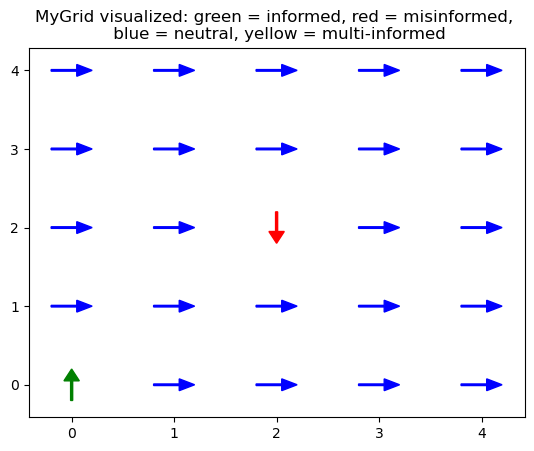

In [51]:
grid2 = Grid(5, 5)
grid2.config[0][0].change_state('t', grid2)
grid2.config[2][2].change_state('f', grid2)
grid2.visual()

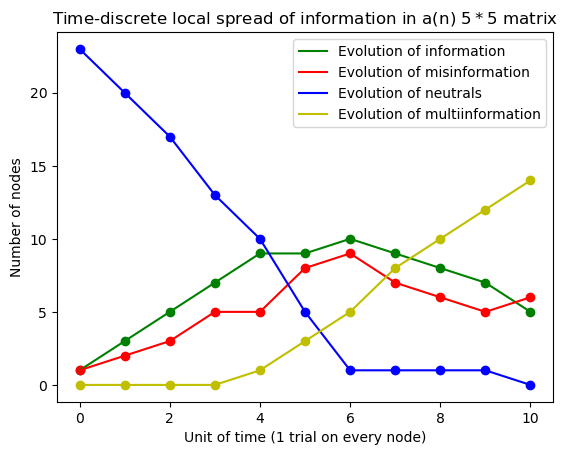

([[ 1.  0.  0.  0.  1.]
  [ 1.  0.  0. -1.  1.]
  [ 0. -1.  0. -1.  0.]
  [ 0.  0.  1. -1. -1.]
  [ 0.  0.  0.  0. -1.]],
 array([ 1,  3,  5,  7,  9,  9, 10,  9,  8,  7,  5]),
 array([1, 2, 3, 5, 5, 8, 9, 7, 6, 5, 6]),
 array([23, 20, 17, 13, 10,  5,  1,  1,  1,  1,  0]),
 array([ 0,  0,  0,  0,  1,  3,  5,  8, 10, 12, 14]),
 0)

In [53]:
grid2.timed_multi_spread_graph(10, p=0.2)

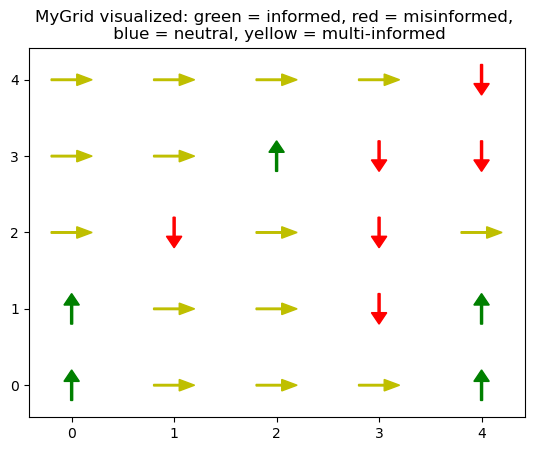

In [57]:
grid2.visual()

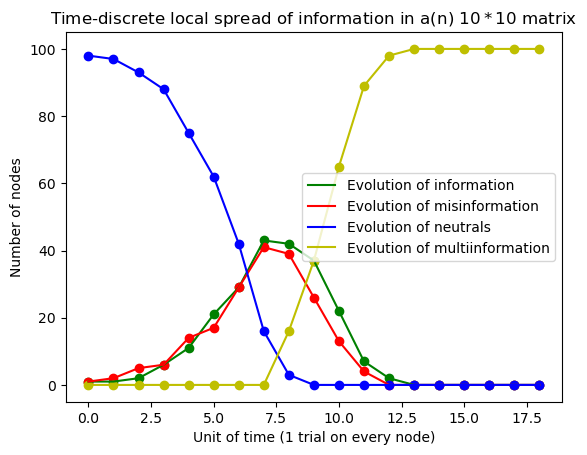

([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 array([ 1,  1,  2,  6, 11, 21, 29, 43, 42, 37, 22,  7,  2,  0,  0,  0,  0,
         0,  0]),
 array([ 1,  2,  5,  6, 14, 17, 29, 41, 39, 26, 13,  4,  0,  0,  0,  0,  0,
         0,  0]),
 array([98, 97, 93, 88, 75, 62, 42, 16,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]),
 array([  0,   0,   0,   0,   0,   0,   0,   0,  16,  37,  65,  89,  98,
        100, 100, 100, 100, 100, 100]),
 13)

In [120]:
grid3 = Grid(10, 10)
grid3.config[0][0].change_state('t', grid3)
grid3.config[5][5].change_state('f', grid3)
grid3.timed_multi_spread_graph(20)

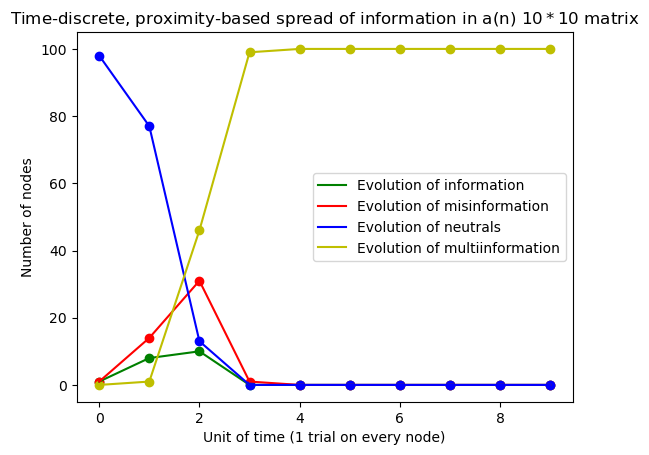

([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 array([ 1,  8, 10,  0,  0,  0,  0,  0,  0,  0]),
 array([ 1, 14, 31,  1,  0,  0,  0,  0,  0,  0]),
 array([98, 77, 13,  0,  0,  0,  0,  0,  0,  0]),
 array([  0,   1,  46,  99, 100, 100, 100, 100, 100, 100]),
 4)

In [116]:
grid4 = Grid(10, 10)
grid4.config[0][0].change_state('t', grid4)
grid4.config[5][5].change_state('f', grid4)
grid4.timed_widely_multi_spread_graph(20)

## 4. Plotting the average evolution

In the scope of this project, I will focus on the propagation patterns of a few specific parameters:
* Grid size: 10x10 (small) or 50x50 (large) for comparison.
* Initial condition: (a) 1 source of information, placed at (0, 0); (b) 2 sources of the same information, placed at (0, 0) and the center of the grid (which is farthest from (0, 0)); (c) 1 source of information, placed at (0, 0), and 1 source of misinformation, placed at the center of the grid. Any 2 of the 3 conditions form parallel experiments in number of sources, type of sources, and presence of misinformation, respectively.
* Exposure probability `p`: default is 0.5, but considered as a variable of interest.
* Propagation mechanisms: (a) local or (b) wide.
* States dictionary with age factors as below.

state_map = {'t': [1, 'correctly informed', 5, 'g'],
             'f': [-1, 'misinformed', 5, 'r'],
             'n': [0, 'uninformed', 0, 'b'],
             'm': [0, 'multi-informed', 2, 'y']}

In [191]:
def time_discrete_spread_multi_trial(N, M, trials, times, p=0.5, states=state_map, sources=source_map, age=False, graph=True):
    """
    Simulates time-discrete, local spread of information in an N*M grid over 'times' units of times and averaged over 'trials' number of
    simulations. Initial condition determined by 'sources', state dictionary by 'states', exposure probability by p.
    """
    infos = np.zeros([times+1])
    misinfos = np.zeros([times+1])
    neutrals = np.zeros([times+1])
    multis = np.zeros([times+1])
    equilibrium = 0
    valid = 0
    
    for time in range(trials):
        grid = Grid(N, M)
        for source in sources:
            grid.config[source[0]][source[1]].change_state(source[2], grid)
        # grid.config[0][0].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('f', grid)
        result = grid.timed_multi_spread_graph(times, p, age, graph=False)
        info = result[1]
        misinfo = result[2]
        neutral = result[3]
        multi = result[4]
        while len(info) < times + 1:
            info = np.append(info, info[-1])
            misinfo = np.append(misinfo, misinfo[-1])
            neutral = np.append(neutral, neutral[-1])
            multi = np.append(multi, multi[-1])
        infos = infos + info
        misinfos = misinfos + misinfo
        neutrals = neutrals + neutral
        multis = multis + multi
        if result[5] != 0:
            valid = valid + 1
            equilibrium = equilibrium + result[5]

    infos = infos / trials
    misinfos = misinfos / trials
    neutrals = neutrals / trials
    multis = multis / trials
    equilibrium = equilibrium / valid

    if graph:
        fig, ax = plt.subplots()
        n = np.arange(times+1)
        ax.plot(n,infos,label= 'Evolution of information',color='g')
        ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
        ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
        ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
        ax.scatter(n,infos,color="g")
        ax.scatter(n,misinfos,color="r")
        ax.scatter(n,neutrals,color='b')
        ax.scatter(n,multis,color='y')
        ax.set_title("Time-discrete local spread of information in \n a(n) " + str(N) + " * " + str(M) + " matrix averaged over " + str(trials) + " trials")
        ax.set_ylabel('Number of nodes')
        ax.set_xlabel('Unit of time (1 trial on every node)')
    
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

    return equilibrium, infos[-1], misinfos[-1], neutrals[-1], multis[-1]

In [247]:
source_map = [(0, 0, 't')]

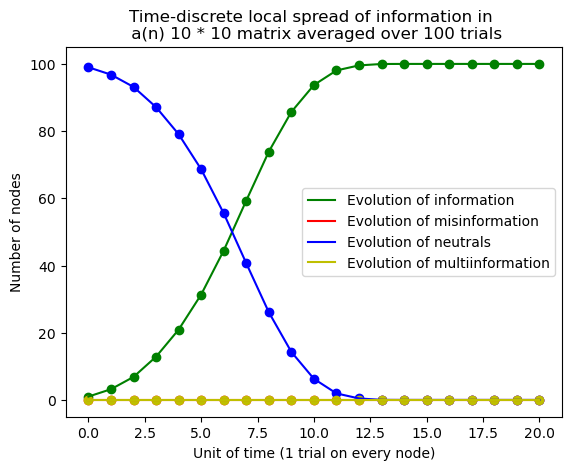

(11.67, 100.0, 0.0, 0.0, 0.0)

In [126]:
time_discrete_spread_multi_trial(10, 10, 100, 20)

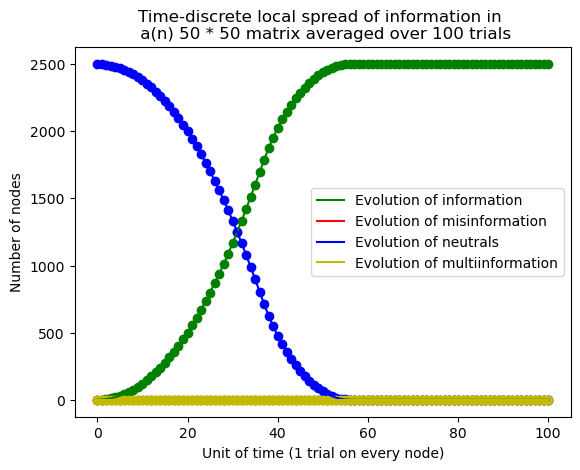

(55.85, 2499.98, 0.0, 0.02, 0.0)

In [138]:
time_discrete_spread_multi_trial(50, 50, 100, 100)

In [140]:
source_map = [(0, 0, 't'), (5, 5, 't')]

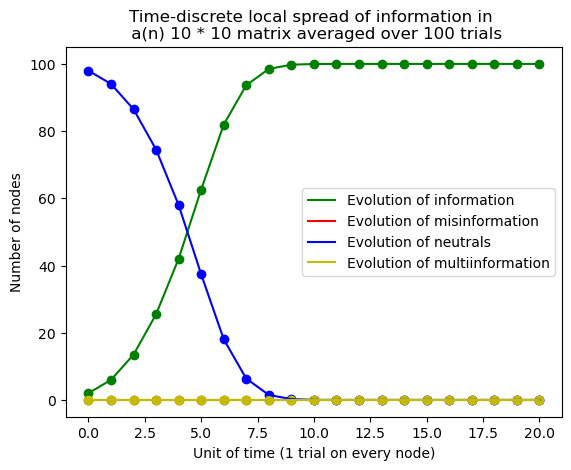

(8.65, 100.0, 0.0, 0.0, 0.0)

In [144]:
time_discrete_spread_multi_trial(10, 10, 100, 20)

In [150]:
source_map = [(0, 0, 't'), (25, 25, 't')]

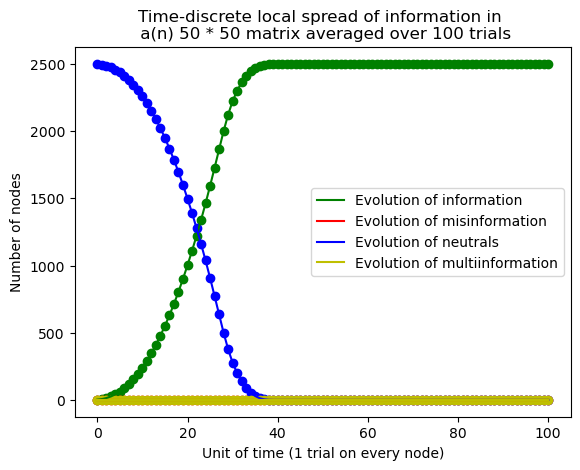

(38.17, 2500.0, 0.0, 0.0, 0.0)

In [154]:
time_discrete_spread_multi_trial(50, 50, 100, 100)

These graphs suggest that having two sources of the same information speeds up propagation and equilibration of information, which can usually equilibrate with every node informed when p=0.5.

The next set of initial conditions introduce misinformation at the farthest point from the correct information.

In [189]:
source_map = [(0, 0, 't'), (5, 5, 'f')]

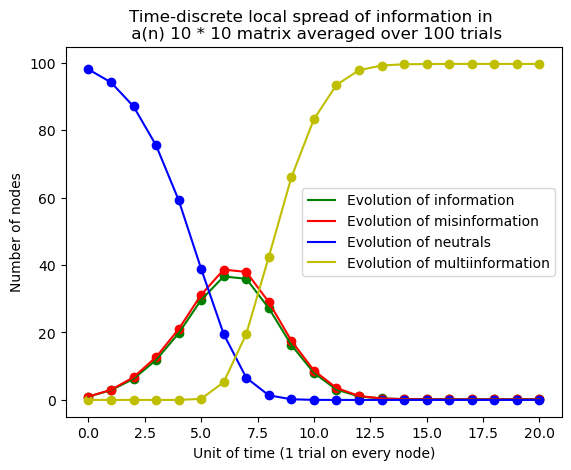

(12.826530612244898, 0.23, 0.15, 0.0, 99.62)

In [160]:
time_discrete_spread_multi_trial(10, 10, 100, 20)

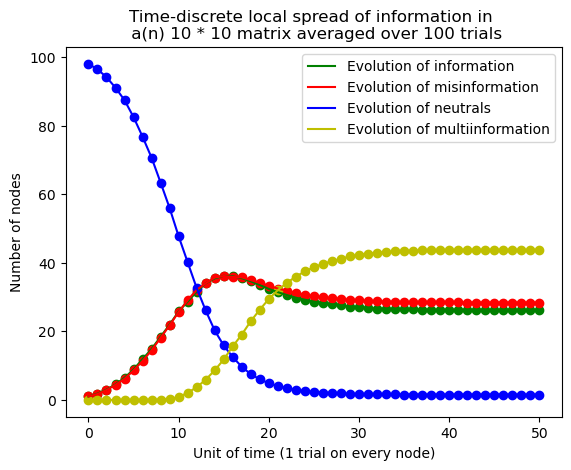

(27.75, 26.28, 28.41, 1.56, 43.75)

In [195]:
time_discrete_spread_multi_trial(10, 10, 100, 50, 0.2)

In [166]:
source_map = [(0, 0, 't'), (25, 25, 'f')]

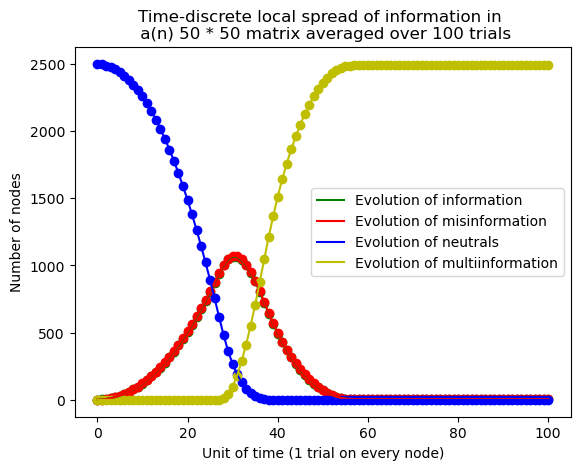

(57.25, 5.82, 6.07, 0.01, 2488.1)

In [170]:
time_discrete_spread_multi_trial(50, 50, 100, 100)

These graphs with misinformation and p=0.5 resemble the ODE results of the SIR model: neutral ≈ susceptible, informed or misinformed ≈ infected, multi-informed ≈ recovered (because misinformation acts as a counterforce or "recovery" agent of information). When p=0.5, the system can usually equilibrate with every node multi-informed.

The following function is based on the proximity-based wide spread of information.

In [238]:
def time_discrete_widespread_multi_trial(N, M, trials, times, p=0.5, states=state_map, sources=source_map, age=False, graph=True):
    infos = np.zeros([times+1])
    misinfos = np.zeros([times+1])
    neutrals = np.zeros([times+1])
    multis = np.zeros([times+1])
    equilibrium = 0
    valid = 0
    
    for time in range(trials):
        grid = Grid(N, M)
        for source in sources:
            grid.config[source[0]][source[1]].change_state(source[2], grid)
        # grid.config[0][0].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('f', grid)
        result = grid.timed_widely_multi_spread_graph(times, p, age, graph=False)
        info = result[1]
        misinfo = result[2]
        neutral = result[3]
        multi = result[4]
        while len(info) < times + 1:
            info = np.append(info, info[-1])
            misinfo = np.append(misinfo, misinfo[-1])
            neutral = np.append(neutral, neutral[-1])
            multi = np.append(multi, multi[-1])
        infos = infos + info
        misinfos = misinfos + misinfo
        neutrals = neutrals + neutral
        multis = multis + multi
        if result[5] != 0:
            valid = valid + 1
            equilibrium = equilibrium + result[5]
        # print(time)

    infos = infos / trials
    misinfos = misinfos / trials
    neutrals = neutrals / trials
    multis = multis / trials
    equilibrium = equilibrium / valid

    if graph:
        fig, ax = plt.subplots()
        n = np.arange(times+1)
        ax.plot(n,infos,label= 'Evolution of information',color='g')
        ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
        ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
        ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
        ax.scatter(n,infos,color="g")
        ax.scatter(n,misinfos,color="r")
        ax.scatter(n,neutrals,color='b')
        ax.scatter(n,multis,color='y')
        ax.set_title("Time-discrete local spread of information in a(n) " + str(N) + " * " + str(M) + " matrix averaged over " + str(trials) + " trials")
        ax.set_ylabel('Number of nodes')
        ax.set_xlabel('Unit of time (1 trial on every node)')
    
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

    return equilibrium, infos[-1], misinfos[-1], neutrals[-1], multis[-1]

In [179]:
source_map = [(0, 0, 't')]

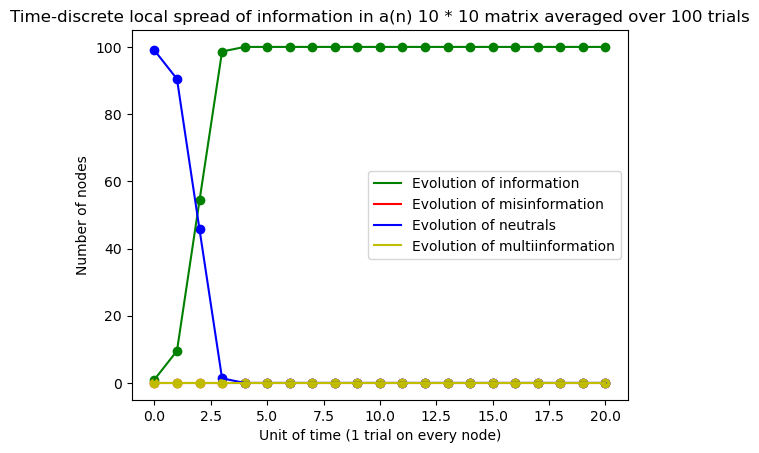

(3.56, 100.0, 0.0, 0.0, 0.0)

In [187]:
time_discrete_widespread_multi_trial(10, 10, 100, 20)

In [236]:
source_map = [(0, 0, 't'), (5, 5, 't')]

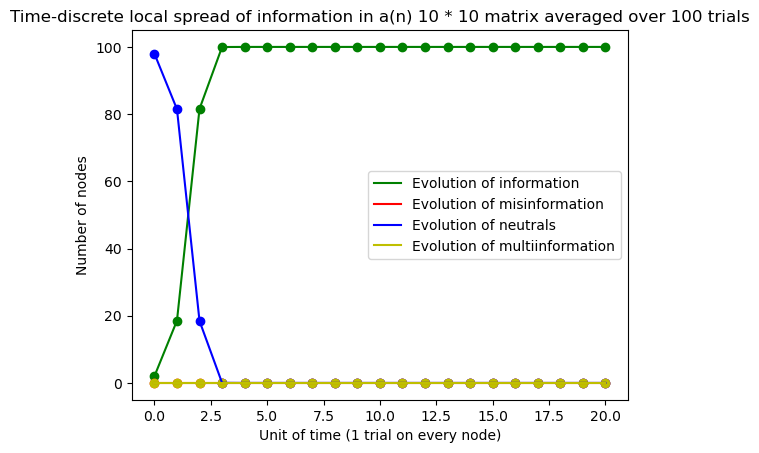

(3.03, 100.0, 0.0, 0.0, 0.0)

In [240]:
time_discrete_widespread_multi_trial(10, 10, 100, 20)

In [230]:
source_map = [(0, 0, 't'), (5, 5, 'f')]

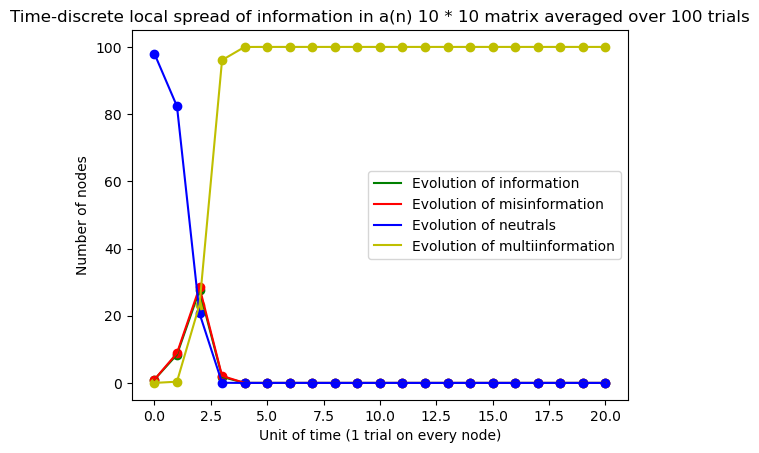

(3.88, 0.0, 0.0, 0.0, 100.0)

In [234]:
time_discrete_widespread_multi_trial(10, 10, 100, 20)

Compared to their counterparts in local mode earlier, these graphs show that for each type of initial condition, the wide propagation mechanism is much faster.

## 5. Comparing equilibration patterns of different initial conditions and probabilities

From the previous part, we defined equilibrium as the first time the grid has been completely stable and different from initial condition for 5 consecutive units of time (the maximum age factor). In this part, we are interested in the patterns of equilibration time and equilibrium ratio as a function of the exposure probability `p`, as well as how this pattern changes with different initial conditions, grid sizes, and local/wide propagation mechanisms.

### Equilibration time

This function plots the average equilibration time (in units of time) as a function of exposure probability in local propagation mode.

In [255]:
def discrete_equi_with_prob(N, M, trials, times, prob=prob_map, states=state_map, sources=source_map, age=False):
    equi = []
    for pr in prob:
        eq = time_discrete_spread_multi_trial(N, M, trials, times, pr, states, sources, age, graph=False)[0]
        equi.append(eq)
        # print(pr)

    fig, ax = plt.subplots()
    n = np.array(prob)
    x = np.array(equi)
    ax.plot(n,x)
    ax.scatter(n,x)
    ax.set_title("Average equilibration time of time-discrete local spread of information in \n a(n) " + str(N) + " * " + str(M) + " matrix with "
     + str(trials) + " trials as a function of exposure probability")
    ax.set_ylabel('Equilibration time (units of time)')
    ax.set_xlabel('Exposure probability between two neighboring nodes in any single unit of time')
    for i, pr in enumerate(n):
        label = str(x[i])
        ax.annotate(label, (pr,x[i]))

    plt.show()
    return equi

In [249]:
prob_map = np.linspace(0.1, 1.0, 10)

source_map = [(0, 0, 't')]

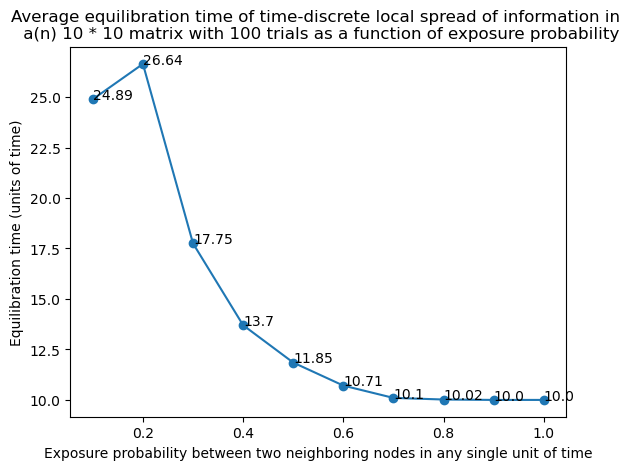

[24.89, 26.64, 17.75, 13.7, 11.85, 10.71, 10.1, 10.02, 10.0, 10.0]

In [257]:
discrete_equi_with_prob(10, 10, 100, 100)

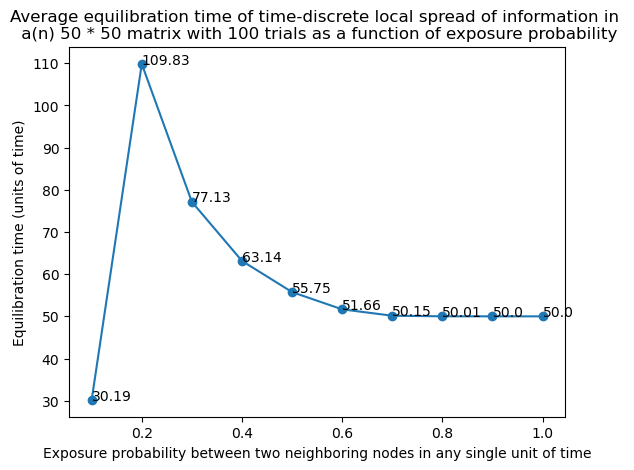

[30.19, 109.83, 77.13, 63.14, 55.75, 51.66, 50.15, 50.01, 50.0, 50.0]

In [1037]:
discrete_equi_with_prob(50, 50, 100, 200)

From these graphs, we can tell that for an age factor of 5, p=0.2 seems to be a critical point where the equilibration time reaches maximum for both of the grid sizes (presumably because of statistical approximations of 5*0.2=1). This might be where the equilibrium transitions from partial to total (to be explored later). Therefore, we next look specifically at p≤0.3.

In [1149]:
prob_map = np.linspace(0.02, 0.30, 15)

0.02
0.039999999999999994
0.06
0.07999999999999999
0.09999999999999999
0.11999999999999998
0.13999999999999999
0.15999999999999998
0.17999999999999997
0.19999999999999996
0.21999999999999995
0.23999999999999996
0.25999999999999995
0.27999999999999997
0.3


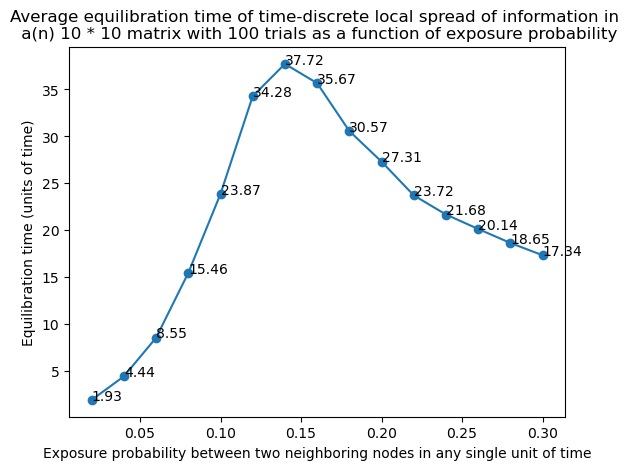

[1.93,
 4.44,
 8.55,
 15.46,
 23.87,
 34.28,
 37.72,
 35.67,
 30.57,
 27.31,
 23.72,
 21.68,
 20.14,
 18.65,
 17.34]

In [1162]:
discrete_equi_with_prob(10, 10, 100, 100)

0.02
0.039999999999999994
0.06
0.07999999999999999
0.09999999999999999
0.11999999999999998
0.13999999999999999
0.15999999999999998
0.17999999999999997
0.19999999999999996
0.21999999999999995
0.23999999999999996
0.25999999999999995
0.27999999999999997
0.3


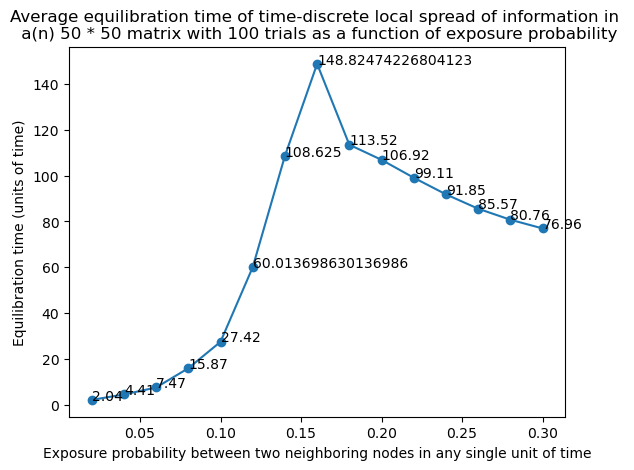

[2.04,
 4.41,
 7.47,
 15.87,
 27.42,
 60.013698630136986,
 108.625,
 148.82474226804123,
 113.52,
 106.92,
 99.11,
 91.85,
 85.57,
 80.76,
 76.96]

In [1164]:
discrete_equi_with_prob(50, 50, 100, 200)

Fomr these two graphs, we see that the peak occurs slightly later for 50x50 (p=0.16) than for 10x10 (p=0.14). The final equilibrium ratio will be explored later.

source_map = [(0, 0, 't'), (5, 5, 't')]

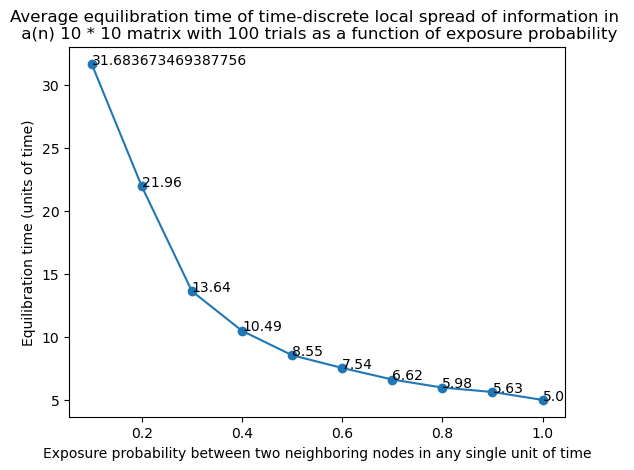

[31.683673469387756, 21.96, 13.64, 10.49, 8.55, 7.54, 6.62, 5.98, 5.63, 5.0]

In [939]:
discrete_equi_with_prob(10, 10, 100, 100)

In [199]:
source_map = [(0, 0, 't'), (25, 25, 't')]

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


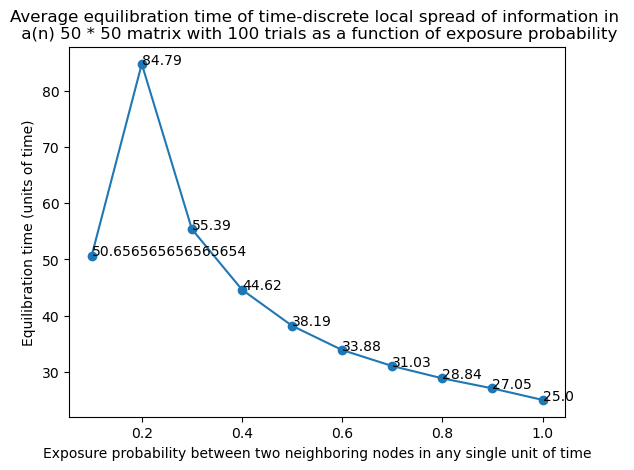

[50.656565656565654,
 84.79,
 55.39,
 44.62,
 38.19,
 33.88,
 31.03,
 28.84,
 27.05,
 25.0]

In [207]:
discrete_equi_with_prob(50, 50, 100, 200)

source_map = [(0, 0, 't'), (5, 5, 'f')]

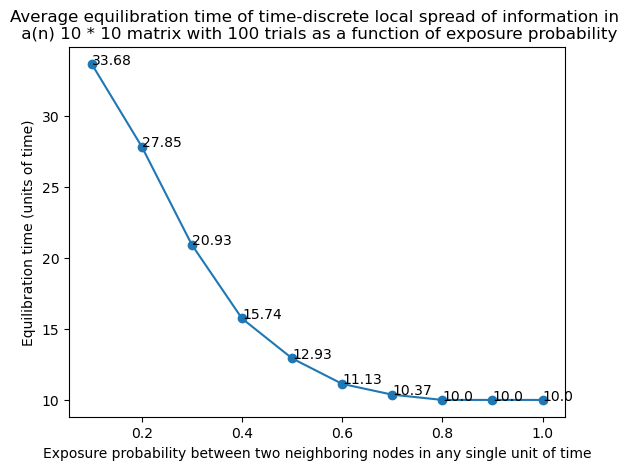

[33.68, 27.85, 20.93, 15.74, 12.93, 11.13, 10.37, 10.0, 10.0, 10.0]

In [1112]:
discrete_equi_with_prob(10, 10, 100, 100)

In [1124]:
source_map = [(0, 0, 't'), (25, 25, 'f')]

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


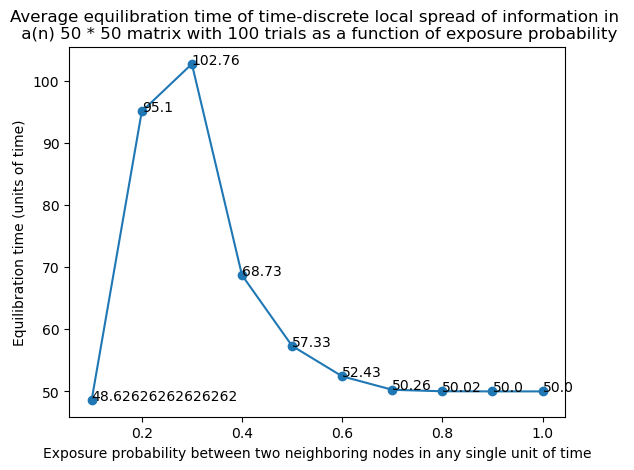

[48.62626262626262,
 95.1,
 102.76,
 68.73,
 57.33,
 52.43,
 50.26,
 50.02,
 50.0,
 50.0]

In [1138]:
discrete_equi_with_prob(50, 50, 100, 200)

Similar patterns are observed in these initial conditions as well.

This function looks at the wide propagation mode.

In [212]:
def discrete_wide_equi_with_prob(N, M, trials, times, prob=prob_map, states=state_map, sources=source_map, age=False):
    equi = []
    for pr in prob:
        eq = time_discrete_widespread_multi_trial(N, M, trials, times, pr, states, sources, age, graph=False)[0]
        equi.append(eq)

    fig, ax = plt.subplots()
    n = np.array(prob)
    x = np.array(equi)
    ax.plot(n,x)
    ax.scatter(n,x)
    ax.set_title("Average equilibration time of time-discrete wide spread of information in \n a(n) " + str(N) + " * " + str(M) + " matrix with "
     + str(trials) + " trials as a function of exposure probability")
    ax.set_ylabel('Equilibration time (units of time)')
    ax.set_xlabel('Exposure probability between two neighboring nodes in any single unit of time')
    for i, pr in enumerate(n):
        label = str(x[i])
        ax.annotate(label, (pr,x[i]))

    plt.show()
    return equi

source_map = [(0, 0, 't')]

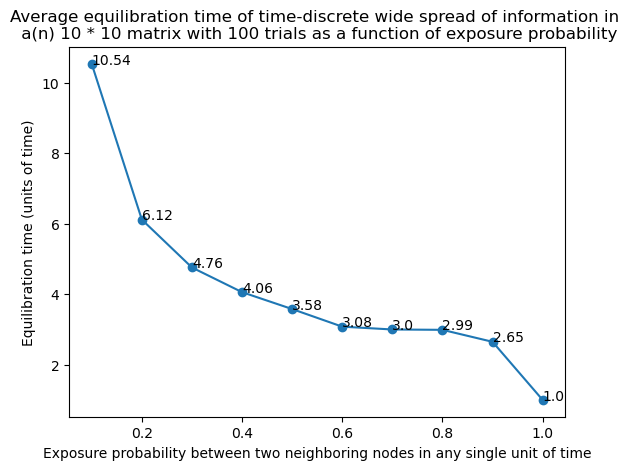

[10.54, 6.12, 4.76, 4.06, 3.58, 3.08, 3.0, 2.99, 2.65, 1.0]

In [1054]:
discrete_wide_equi_with_prob(10, 10, 100, 100)

source_map = [(0, 0, 't'), (5, 5, 't')]

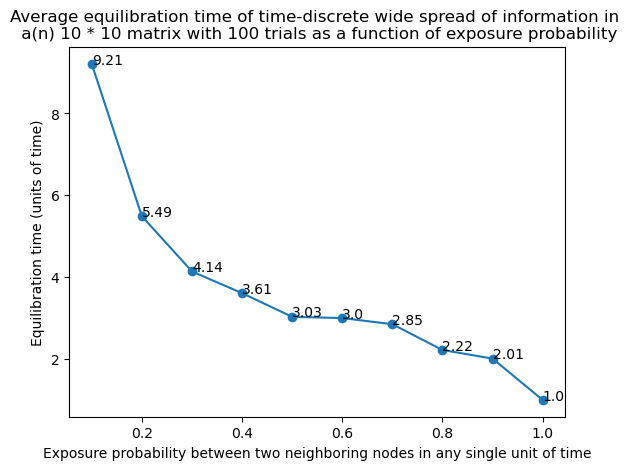

[9.21, 5.49, 4.14, 3.61, 3.03, 3.0, 2.85, 2.22, 2.01, 1.0]

In [214]:
discrete_wide_equi_with_prob(10, 10, 100, 100)

source_map = [(0, 0, 't'), (5, 5, 'f')]

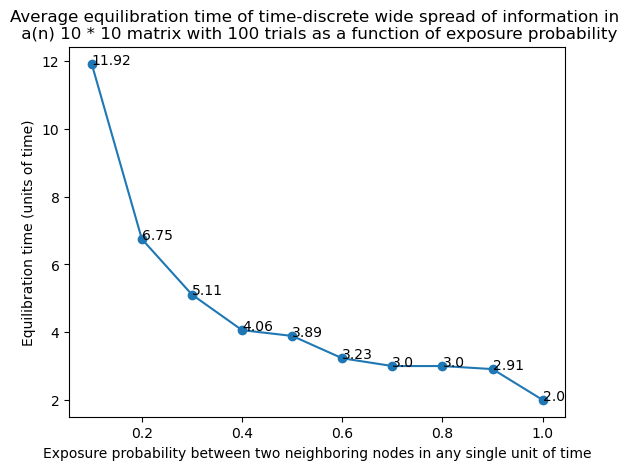

[11.92, 6.75, 5.11, 4.06, 3.89, 3.23, 3.0, 3.0, 2.91, 2.0]

In [1117]:
discrete_wide_equi_with_prob(10, 10, 100, 100)

Compared to their local propagation counterparts, these graphs show that equilibrium is reached significantly faster in the wide propagation mode, which verifies the finding in the previous section. The curves are monotonically decreasing here instead of having a maximum equilibration time (or have a maximum where p<0.1), which potentially implies that total equilibrium is more likely to be reached in lower exposure probabilities (to be explored in the next section). <br>
A different patten is the equilibration time at p=1.0: it is always 1 without misinformation and 2 with misinformation, because change of state is guaranteed in one unit of time, resulting in a break from the rather smooth curve earlier.

### Equilibrium ratio

This following function plots the equilibrium ratios of the four information states as a function of exposure probability in the local propagation mode.

In [1293]:
def discrete_ratio_with_prob(N, M, trials, times, prob=prob_map, states=state_map, sources=source_map, age=False):
    info = []
    misinfo = []
    neutral = []
    multi = []
    
    for pr in prob:
        result = time_discrete_spread_multi_trial(N, M, trials, times, pr, states, sources, age, graph=False)
        info.append(result[1] / (N*M))
        misinfo.append(result[2] / (N*M))
        neutral.append(result[3] / (N*M))
        multi.append(result[4] / (N*M))
        print(pr)

    fig, ax = plt.subplots()
    n = np.array(prob)
    info = np.array(info)
    misinfo = np.array(misinfo)
    neutral = np.array(neutral)
    multi = np.array(multi)
    ax.plot(n,info,label= 'Equilibrium ratio of information',color='g')
    ax.plot(n,misinfo,label= 'Equilibrium ratio of misinformation',color='r')
    ax.plot(n,neutral,label= 'Equilibrium ratio of neutrals',color='b')
    ax.plot(n,multi,label= 'Equilibrium ratio of multiinformation',color='y')
    ax.scatter(n,info,color="g")
    ax.scatter(n,misinfo,color="r")
    ax.scatter(n,neutral,color='b')
    ax.scatter(n,multi,color='y')
    ax.set_title("Equilibrium ratio of nodes of different states via time-discrete \n local spread of information in a(n) " + str(N) + " * " + str(M) + " matrix \n with "
     + str(trials) + " trials as a function of exposure probability")
    ax.set_ylabel('Equilibrium ratio (out of all nodes)')
    ax.set_xlabel('Exposure probability between two neighboring nodes in any single unit of time')
    # for i, pr in enumerate(n):
    #     label = str(x[i])
    #     ax.annotate(label, (pr,x[i]))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()
    return info, misinfo, neutral, multi

source_map = [(0, 0, 't')]

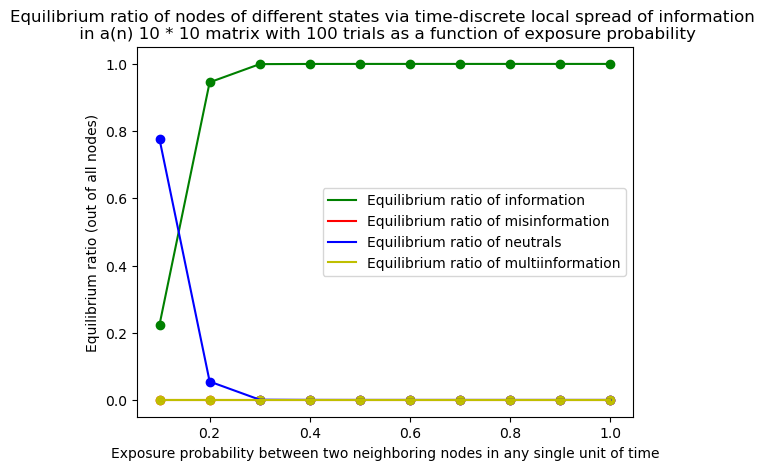

(array([0.2244, 0.9453, 0.9994, 0.9999, 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([7.756e-01, 5.470e-02, 6.000e-04, 1.000e-04, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [974]:
discrete_ratio_with_prob(10, 10, 100, 100)

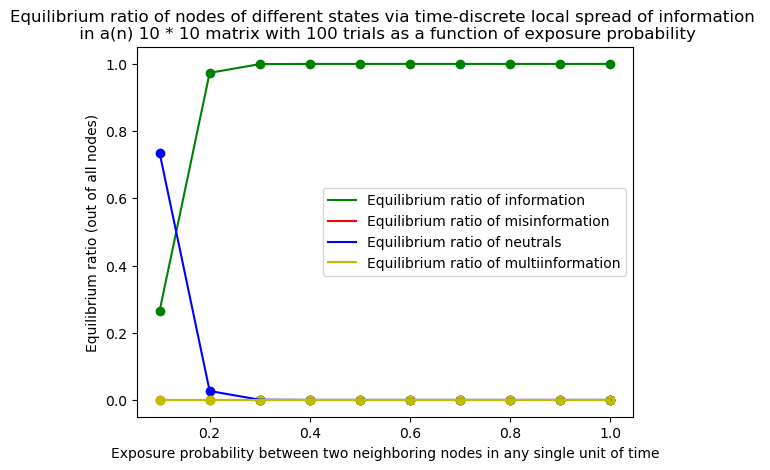

(array([0.264 , 0.9735, 0.9994, 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([7.36e-01, 2.65e-02, 6.00e-04, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1035]:
discrete_ratio_with_prob(10, 10, 100, 100)

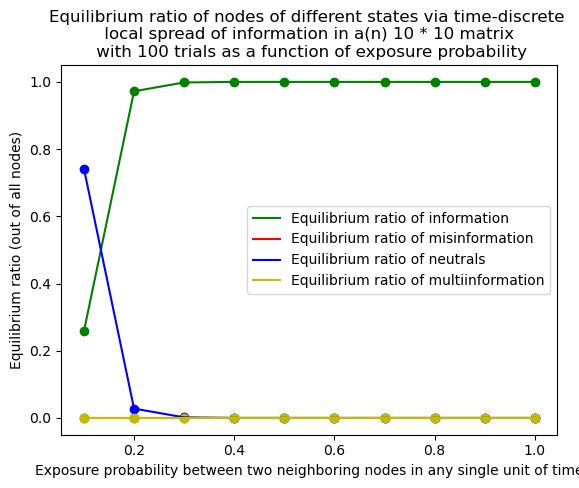

(array([0.2584, 0.9722, 0.9984, 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.7416, 0.0278, 0.0016, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1283]:
discrete_ratio_with_prob(10, 10, 100, 100)

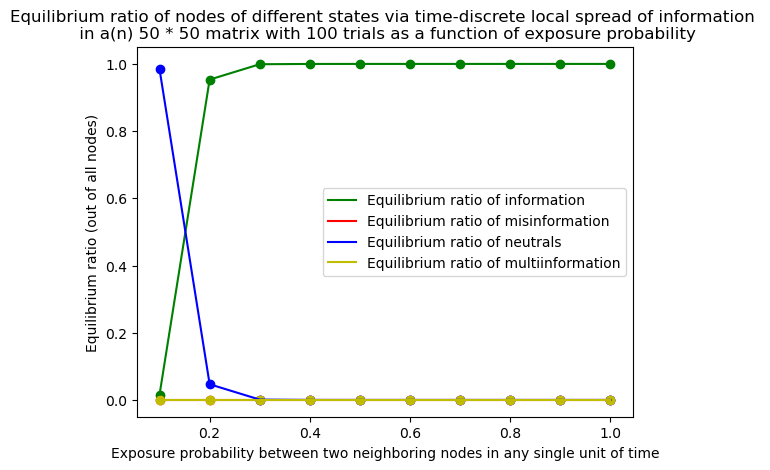

(array([0.015912, 0.953344, 0.999084, 0.999928, 0.999996, 1.      ,
        1.      , 1.      , 1.      , 1.      ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([9.84088e-01, 4.66560e-02, 9.16000e-04, 7.20000e-05, 4.00000e-06,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1039]:
discrete_ratio_with_prob(50, 50, 100, 200)

In [1285]:
prob_map = np.linspace(0.02, 0.30, 15)

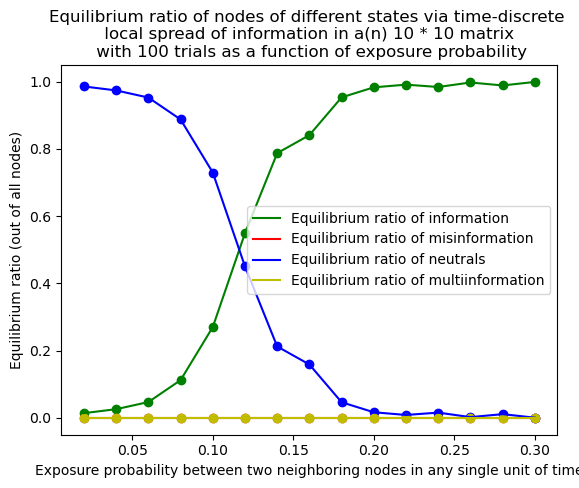

(array([0.0142, 0.026 , 0.0472, 0.1123, 0.2702, 0.5494, 0.7875, 0.8411,
        0.9534, 0.9832, 0.9912, 0.9842, 0.9976, 0.9888, 0.9993]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([9.858e-01, 9.740e-01, 9.528e-01, 8.877e-01, 7.298e-01, 4.506e-01,
        2.125e-01, 1.589e-01, 4.660e-02, 1.680e-02, 8.800e-03, 1.580e-02,
        2.400e-03, 1.120e-02, 7.000e-04]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1291]:
discrete_ratio_with_prob(10, 10, 100, 100)

0.02
0.039999999999999994
0.06
0.07999999999999999
0.09999999999999999
0.11999999999999998
0.13999999999999999
0.15999999999999998
0.17999999999999997
0.19999999999999996
0.21999999999999995
0.23999999999999996
0.25999999999999995
0.27999999999999997
0.3


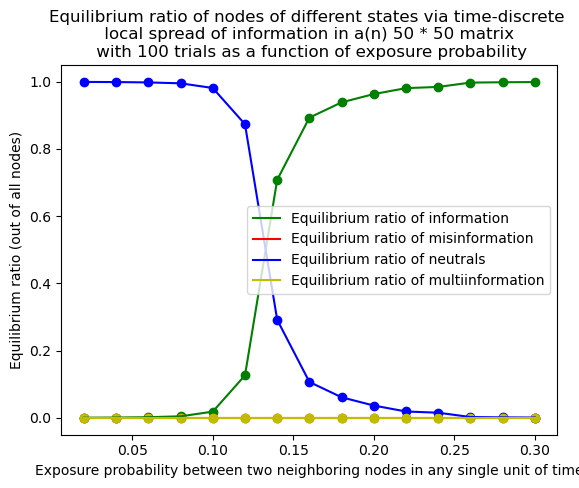

(array([6.40000e-04, 1.06400e-03, 2.14000e-03, 4.77200e-03, 1.87200e-02,
        1.26508e-01, 7.08176e-01, 8.93104e-01, 9.38624e-01, 9.63216e-01,
        9.80888e-01, 9.84504e-01, 9.97332e-01, 9.98384e-01, 9.98908e-01]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.99936 , 0.998936, 0.99786 , 0.995228, 0.98128 , 0.873492,
        0.291824, 0.106896, 0.061376, 0.036784, 0.019112, 0.015496,
        0.002668, 0.001616, 0.001092]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1295]:
discrete_ratio_with_prob(50, 50, 100, 200)

These graphs verify the observation in the equilibration time graphs that around p=0.2, the equilibrium transitions from partial (different information states remain) to total (almost all nodes are dominated by the final state, which is "informed" here). It is also verified that the transition happens slightly earlier for the smaller 10x10 grid than for the larger 50x50 grid.

source_map = [(0, 0, 't'), (5, 5, 't')]

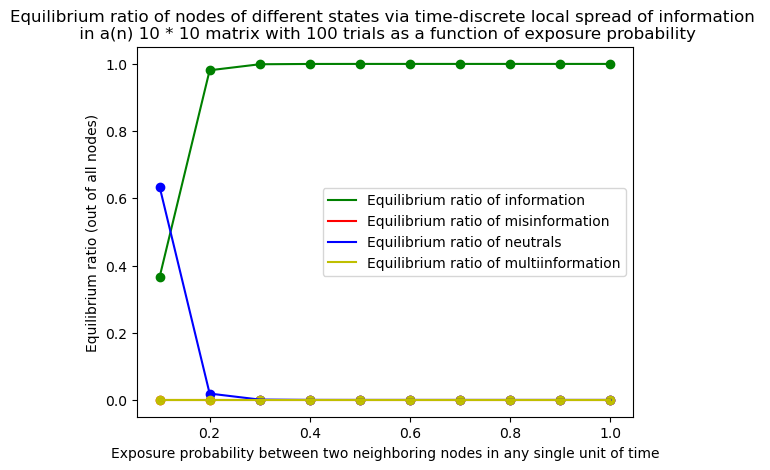

(array([0.3649, 0.9811, 0.999 , 0.9999, 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([6.351e-01, 1.890e-02, 1.000e-03, 1.000e-04, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [957]:
discrete_ratio_with_prob(10, 10, 100, 100)

source_map = [(0, 0, 't'), (5, 5, 'f')]

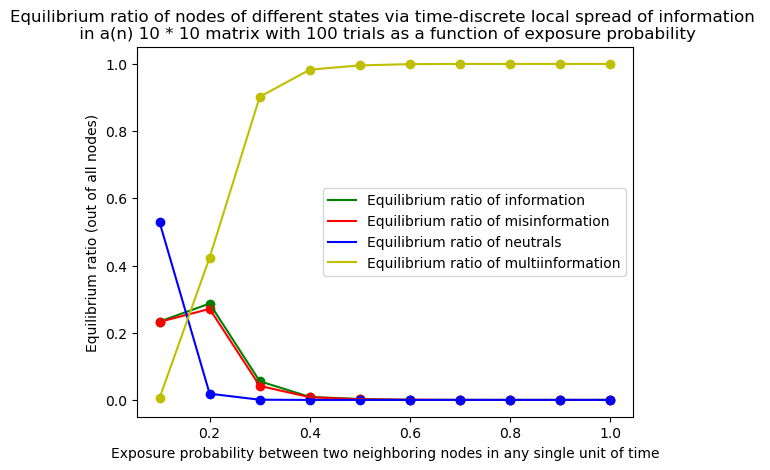

(array([2.332e-01, 2.868e-01, 5.550e-02, 8.900e-03, 2.600e-03, 1.000e-04,
        1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0.2323, 0.2709, 0.0417, 0.0081, 0.0018, 0.0005, 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.529 , 0.0185, 0.0006, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.0055, 0.4238, 0.9022, 0.983 , 0.9956, 0.9994, 0.9999, 1.    ,
        1.    , 1.    ]))

In [1106]:
discrete_ratio_with_prob(10, 10, 100, 100)

source_map = [(0, 0, 't'), (25, 25, 'f')]

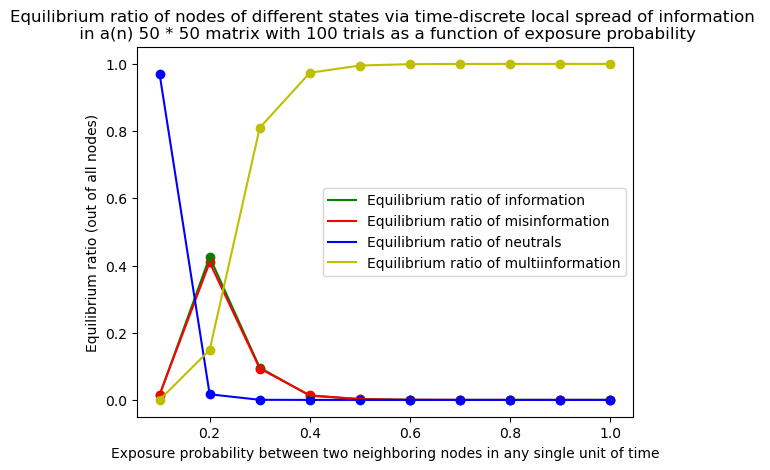

(array([1.36760e-02, 4.25176e-01, 9.59800e-02, 1.24920e-02, 2.63600e-03,
        3.80000e-04, 2.80000e-05, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([1.52000e-02, 4.09448e-01, 9.34760e-02, 1.38240e-02, 2.11600e-03,
        3.88000e-04, 2.40000e-05, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([9.71124e-01, 1.67680e-02, 3.52000e-04, 3.20000e-05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([0.      , 0.148608, 0.810192, 0.973652, 0.995248, 0.999232,
        0.999948, 1.      , 1.      , 1.      ]))

In [1145]:
discrete_ratio_with_prob(50, 50, 100, 200)

In these graphs with the presence of misinformation, we also see a similar transitional pattern: between p=0.1 and p=0.4, where the dominating state shifts from neutral to informed/misinformed to multi-informed.

The following function plots the equilibrium ratios as a function of exposure probability in the wide propagation mode.

In [1143]:
def discrete_wide_ratio_with_prob(N, M, trials, times, prob=prob_map, states=state_map, sources=source_map, age=False):
    info = []
    misinfo = []
    neutral = []
    multi = []
    
    for pr in prob:
        result = time_discrete_widespread_multi_trial(N, M, trials, times, pr, states, sources, age, graph=False)
        info.append(result[1] / (N*M))
        misinfo.append(result[2] / (N*M))
        neutral.append(result[3] / (N*M))
        multi.append(result[4] / (N*M))

    fig, ax = plt.subplots()
    n = np.array(prob)
    info = np.array(info)
    misinfo = np.array(misinfo)
    neutral = np.array(neutral)
    multi = np.array(multi)
    ax.plot(n,info,label= 'Equilibrium ratio of information',color='g')
    ax.plot(n,misinfo,label= 'Equilibrium ratio of misinformation',color='r')
    ax.plot(n,neutral,label= 'Equilibrium ratio of neutrals',color='b')
    ax.plot(n,multi,label= 'Equilibrium ratio of multiinformation',color='y')
    ax.scatter(n,info,color="g")
    ax.scatter(n,misinfo,color="r")
    ax.scatter(n,neutral,color='b')
    ax.scatter(n,multi,color='y')
    ax.set_title("Equilibrium ratio of nodes of different states via time-discrete wide spread of information \n in a(n) " + str(N) + " * " + str(M) + " matrix with "
     + str(trials) + " trials as a function of exposure probability")
    ax.set_ylabel('Equilibrium ratio (out of all nodes)')
    ax.set_xlabel('Exposure probability between two neighboring nodes in any single unit of time')
    # for i, pr in enumerate(n):
    #     label = str(x[i])
    #     ax.annotate(label, (pr,x[i]))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()
    return info, misinfo, neutral, multi

source_map = [(0, 0, 't')]

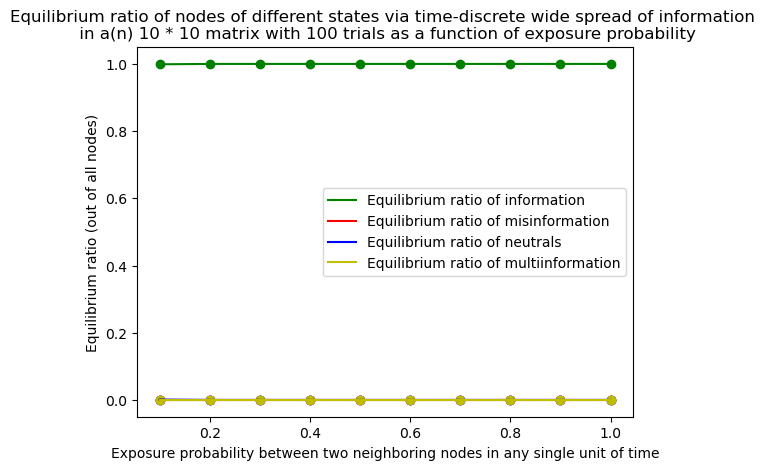

(array([0.9989, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.0011, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [1060]:
discrete_wide_ratio_with_prob(10, 10, 100, 20)

source_map = [(0, 0, 't'), (5, 5, 'f')]

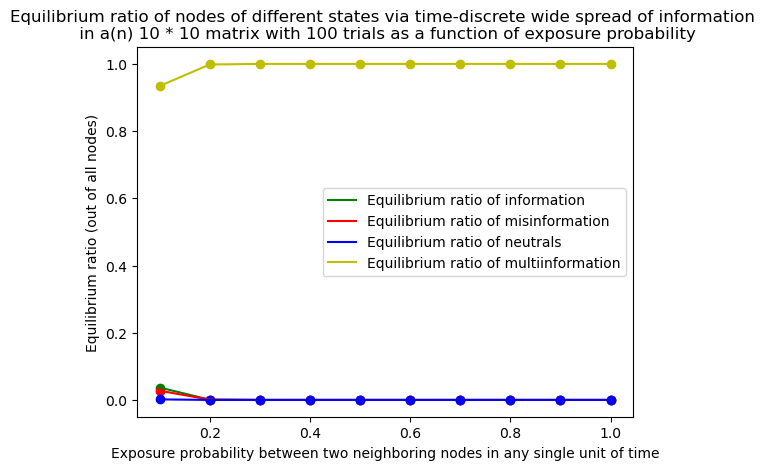

(array([0.0369, 0.0007, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.0273, 0.001 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.0016, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]),
 array([0.9342, 0.9983, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    ]))

In [1122]:
discrete_wide_ratio_with_prob(10, 10, 100, 20)

These graphs also verify the speculation that when p≥0.1, total equilibrium is always reached in the wide propagation mode.

The next function attempts to plot the equilibraiton time function of the two different propagation mechanisms and two differnt initial conditions (with and without misinformation) together for direct comparison.

In [1225]:
def discrete_compare_equi_with_prob(N, M, trials, times, prob=prob_map, states=state_map, sources=source_map, age=False):
    equi_local = []
    equi_wide = []
    equi_local2 = []
    equi_wide2 = []
    for pr in prob:
        source_map1 = [(0, 0, 't')]
        eq_local = time_discrete_spread_multi_trial(N, M, trials, times, pr, states, source_map1, age, graph=False)[0]
        eq_wide = time_discrete_widespread_multi_trial(N, M, trials, times, pr, states, source_map1, age, graph=False)[0]
        equi_local.append(eq_local)
        equi_wide.append(eq_wide)

        source_map2 = [(0, 0, 't'), (5, 5, 'f')]
        eq_local2 = time_discrete_spread_multi_trial(N, M, trials, times, pr, states, source_map2, age, graph=False)[0]
        eq_wide2 = time_discrete_widespread_multi_trial(N, M, trials, times, pr, states, source_map2, age, graph=False)[0]
        equi_local2.append(eq_local2)
        equi_wide2.append(eq_wide2)
        
        print(pr)

    fig, ax = plt.subplots()
    n = np.array(prob)
    x1 = np.array(equi_local)
    x2 = np.array(equi_wide)
    ax.plot(n,x1)
    ax.plot(n,x2)
    ax.scatter(n,x1,label='Local without misinformation')
    ax.scatter(n,x2,label='Wide without misinformation')

    x3 = np.array(equi_local2)
    x4 = np.array(equi_wide2)
    ax.plot(n,x3)
    ax.plot(n,x4)
    ax.scatter(n,x3,label='Local with misinformation')
    ax.scatter(n,x4,label='Wide with misinformation')
    
    ax.set_title("Average equilibration time of time-discrete spread of information in \n a(n) " + str(N) + " * " + str(M) + " matrix with "
     + str(trials) + " trials as a function of exposure probability")
    ax.set_ylabel('Equilibration time (units of time)')
    ax.set_xlabel('Exposure probability between two neighboring nodes in any single unit of time')
    for i, pr in enumerate(n):
        label1 = str(x1[i])
        label2 = str(x2[i])
        ax.annotate(label1, (pr-0.05,x1[i]-1), color='b')
        ax.annotate(label2, (pr-0.05,x2[i]-1), color='orange')

        label3 = str(x3[i])
        label4 = str(x4[i])
        ax.annotate(label3, (pr,x3[i]+0.5), color='g')
        ax.annotate(label4, (pr,x4[i]+0.5), color='r')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

    plt.show()
    return equi_local, equi_wide, equi_local2, equi_wide2

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


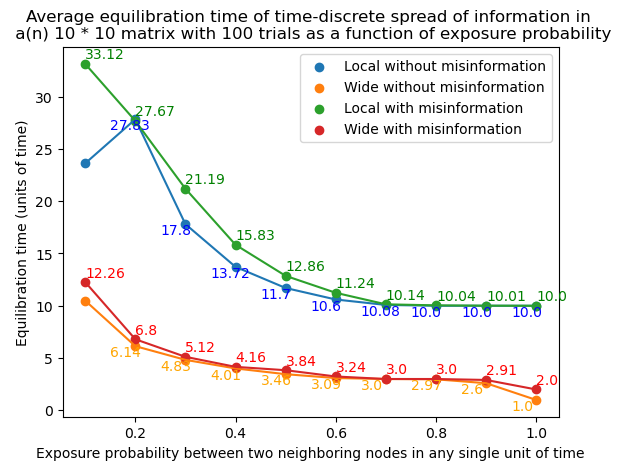

([23.616161616161616, 27.83, 17.8, 13.72, 11.7, 10.6, 10.08, 10.0, 10.0, 10.0],
 [10.49, 6.14, 4.83, 4.01, 3.46, 3.09, 3.0, 2.97, 2.6, 1.0],
 [33.12, 27.67, 21.19, 15.83, 12.86, 11.24, 10.14, 10.04, 10.01, 10.0],
 [12.26, 6.8, 5.12, 4.16, 3.84, 3.24, 3.0, 3.0, 2.91, 2.0])

In [1227]:
discrete_compare_equi_with_prob(10, 10, 100, 100)

From this graph, we can tell that setting a neutral node to a misinformed initial state has little effect on the equilibration time for the grid. A much more marked distinction is observed between the local and wide propagation mechanisms, whose equilibration time differs by a factor of about 4.

## 6. Other definitions of time

The following section contains trials and plots average propagation process of the free-spread and time-dependent definitions of time.

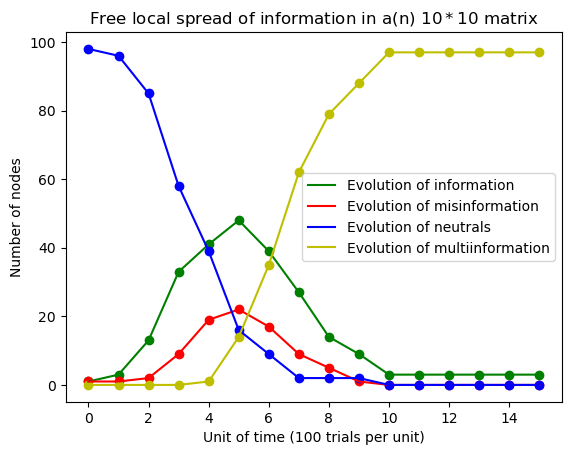

([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 array([ 1,  3, 13, 33, 41, 48, 39, 27, 14,  9,  3,  3,  3,  3,  3,  3]),
 array([ 1,  1,  2,  9, 19, 22, 17,  9,  5,  1,  0,  0,  0,  0,  0,  0]),
 array([98, 96, 85, 58, 39, 16,  9,  2,  2,  2,  0,  0,  0,  0,  0,  0]),
 array([ 0,  0,  0,  0,  1, 14, 35, 62, 79, 88, 97, 97, 97, 97, 97, 97]),
 10)

In [105]:
grid3 = Grid(10, 10)
grid3.config[0][0].change_state('t', grid3)
grid3.config[5][5].change_state('f', grid3)
grid3.free_multi_spread_graph(20)

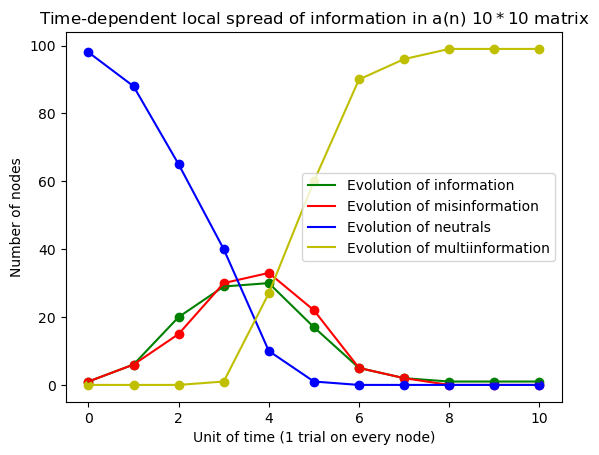

([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 array([ 1,  6, 20, 29, 30, 17,  5,  2,  1,  1,  1]),
 array([ 1,  6, 15, 30, 33, 22,  5,  2,  0,  0,  0]),
 array([98, 88, 65, 40, 10,  1,  0,  0,  0,  0,  0]),
 array([ 0,  0,  0,  1, 27, 60, 90, 96, 99, 99, 99]))

In [701]:
grid10 = Grid(10, 10)
grid10.config[0][0].change_state('t', grid10)
grid10.config[5][5].change_state('f', grid10)
grid10.multi_spread_graph(10)

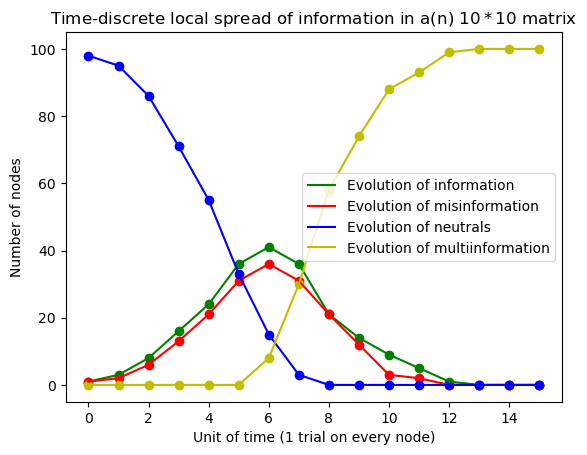

([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 array([ 1,  3,  8, 16, 24, 36, 41, 36, 21, 14,  9,  5,  1,  0,  0,  0]),
 array([ 1,  2,  6, 13, 21, 31, 36, 31, 21, 12,  3,  2,  0,  0,  0,  0]),
 array([98, 95, 86, 71, 55, 33, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([  0,   0,   0,   0,   0,   0,   8,  30,  58,  74,  88,  93,  99,
        100, 100, 100]))

In [669]:
grid11 = Grid(10, 10)
grid11.config[0][0].change_state('t', grid11)
grid11.config[5][5].change_state('f', grid11)
grid11.timed_multi_spread_graph(15, age=True)

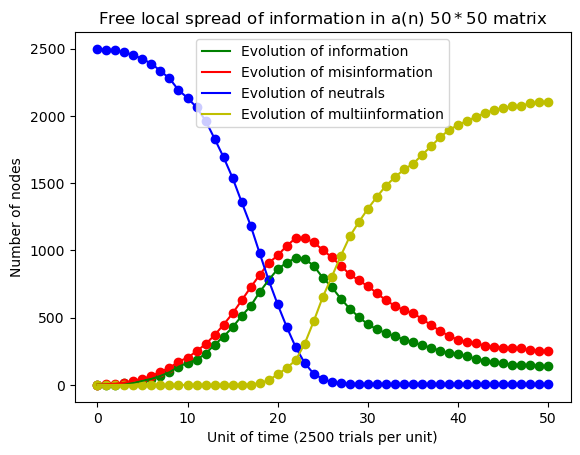

([[0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]],
 array([  1,   2,   3,  11,  17,  31,  45,  67,  94, 135, 164, 186, 232,
        299, 359, 429, 512, 587, 690, 780, 861, 909, 944, 938, 885, 797,
        727, 641, 566, 505, 450, 414, 385, 363, 337, 320, 294, 278, 254,
        236, 229, 212, 195, 181, 169, 160, 151, 149, 146, 142, 139]),
 array([   1,    5,    9,   17,   30,   46,   66,   99,  127,  173,  202,
         250,  303,  370,  448,  532,  628,  725,  818,  906,  963, 1034,
        1092, 1093, 1059, 1004,  948,  887,  821,  777,  734,  682,  629,
         588,  556,  533,  492,  444,  402,  364,  335,  320,  308,  293,
         283,  277,  275,  271,  257,  254,  251]),
 array([2498, 2493, 2488, 2472, 2453, 2423, 2389, 2334, 2279, 2192, 2134,
        2064, 1965, 1831, 1693, 1539, 1360, 1185,  979,  779,  598,  431,
         280,  162,   82,   45,   21,   12,    8,  

In [719]:
grid49 = Grid(50, 50)
grid49.config[0][0].change_state('t', grid49)
grid49.config[25][25].change_state('f', grid49)
grid49.free_multi_spread_graph(50)

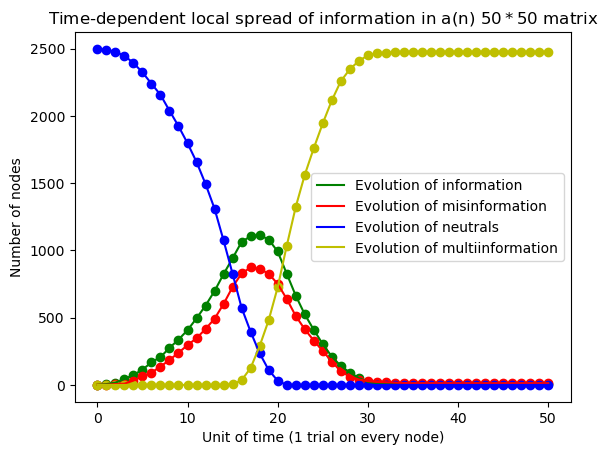

([[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]],
 array([   1,    6,   17,   44,   74,  113,  168,  207,  275,  337,  407,
         495,  590,  698,  824,  942, 1063, 1106, 1114, 1081,  992,  827,
         664,  525,  410,  303,  211,  141,   92,   51,   22,   13,   10,
          10,   10,   10,   10,   10,   10,   10,   10,   10,   10,   10,
          10,   10,   10,   10,   10,   10,   10]),
 array([  1,   1,   6,   9,  32,  63,  92, 136, 186, 239, 296, 347, 416,
        492, 602, 728, 829, 873, 862, 827, 751, 640, 513, 414, 330, 252,
        174, 101,  61,  40,  28,  22,  20,  17,  14,  13,  13,  13,  13,
         13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13]),
 array([2498, 2493, 2477, 2447, 2394, 2324, 2240, 2157, 2039, 1924, 1797,
        1658, 1494, 1310, 1074,  826,  573,  395,  235,  111,   31,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [673]:
grid50 = Grid(50, 50)
grid50.config[0][0].change_state('t', grid50)
grid50.config[25][25].change_state('f', grid50)
grid50.multi_spread_graph(50)

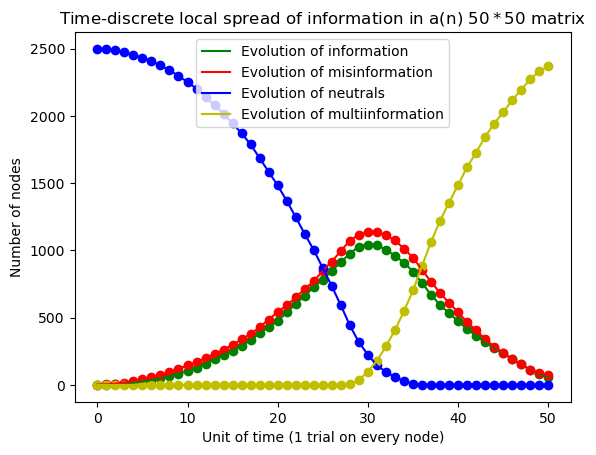

([[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 0. 0. ... 0. 1. 1.]
  [1. 1. 0. ... 0. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]],
 array([   1,    2,    4,    9,   16,   25,   36,   50,   64,   84,  102,
         128,  157,  190,  225,  255,  292,  332,  385,  430,  475,  539,
         602,  664,  727,  782,  849,  912,  977, 1029, 1043, 1038, 1006,
         960,  910,  843,  759,  670,  595,  534,  474,  415,  366,  316,
         273,  234,  195,  152,  114,   81,   59]),
 array([   1,    4,    9,   18,   29,   41,   57,   75,   95,  119,  146,
         170,  200,  231,  260,  300,  338,  380,  429,  486,  542,  592,
         650,  714,  770,  849,  917,  996, 1073, 1117, 1134, 1138, 1111,
        1075, 1013,  947,  856,  767,  685,  610,  541,  466,  407,  340,
         284,  238,  190,  152,  114,   88,   71]),
 array([2498, 2494, 2487, 2473, 2455, 2434, 2407, 2375, 2341, 2297, 2252,
        2202, 2143, 2079, 2015, 1945, 1870, 1788, 1686, 1584, 1483

In [675]:
grid51 = Grid(50, 50)
grid51.config[0][0].change_state('t', grid51)
grid51.config[25][25].change_state('f', grid51)
grid51.timed_multi_spread_graph(50)

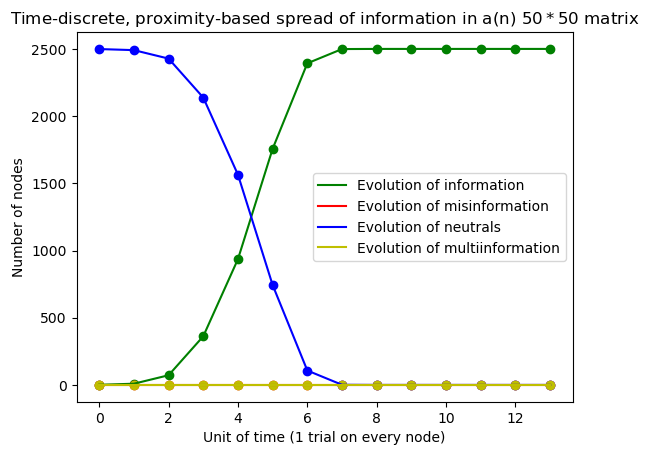

([[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]],
 array([   1,    9,   72,  362,  936, 1757, 2393, 2499, 2500, 2500, 2500,
        2500, 2500, 2500]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([2499, 2491, 2428, 2138, 1564,  743,  107,    1,    0,    0,    0,
           0,    0,    0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 8)

In [1074]:
grid52 = Grid(50, 50)
grid52.config[0][0].change_state('t', grid52)
# grid52.config[25][25].change_state('f', grid52)
grid52.timed_widely_multi_spread_graph(100)

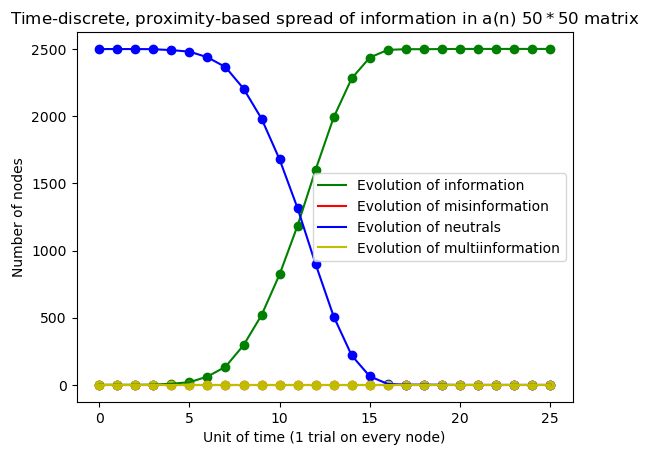

([[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]],
 array([   1,    1,    1,    2,    9,   20,   62,  135,  295,  519,  822,
        1186, 1602, 1991, 2281, 2436, 2493, 2498, 2498, 2499, 2500, 2500,
        2500, 2500, 2500, 2500]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 array([2499, 2499, 2499, 2498, 2491, 2480, 2438, 2365, 2205, 1981, 1678,
        1314,  898,  509,  219,   64,    7,    2,    2,    1,    0,    0,
           0,    0,    0,    0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 20)

In [1076]:
grid53 = Grid(50, 50)
grid53.config[0][0].change_state('t', grid53)
# grid52.config[25][25].change_state('f', grid52)
grid53.timed_widely_multi_spread_graph(100, p=0.1)

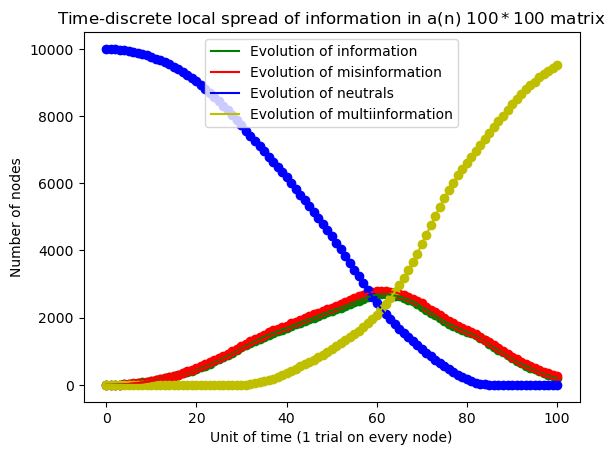

([[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]],
 array([   1,    3,    6,   11,   19,   28,   41,   62,   75,   94,  122,
         149,  176,  204,  233,  268,  304,  342,  380,  423,  470,  520,
         576,  636,  698,  760,  820,  888,  964, 1038, 1122, 1191, 1252,
        1316, 1379, 1440, 1500, 1546, 1592, 1644, 1691, 1744, 1801, 1852,
        1909, 1953, 1992, 2049, 2104, 2159, 2210, 2254, 2296, 2348, 2413,
        2459, 2512, 2565, 2610, 2661, 2683, 2695, 2700, 2685, 2658, 2634,
        2591, 2539, 2488, 2410, 2315, 2241, 2154, 2068, 1979, 1896, 1818,
        1765, 1705, 1642, 1581, 1532, 1473, 1398, 1323, 1230, 1135, 1052,
         978,  882,  802,  722,  648,  570,  518,  470,  410,  357,  307,
         256,  208]),
 array([   1,    2,    6,   10,   17,   30,   43,   55,   71,   89,  114,
         139,  167,  200,  230,  267,  308,  349,  401,  444,  496,  549,


In [677]:
grid101 = Grid(100, 100)
grid101.config[0][0].change_state('t', grid101)
grid101.config[25][25].change_state('f', grid101)
grid101.timed_multi_spread_graph(100)

In [108]:
def free_spread_multi_trial(N, M, trials, times, p=0.5, states=state_map, sources=source_map, age=False, graph=True):
    infos = np.zeros([times+1])
    misinfos = np.zeros([times+1])
    neutrals = np.zeros([times+1])
    multis = np.zeros([times+1])
    equilibrium = 0
    valid = 0
    
    for time in range(trials):
        grid = Grid(N, M)
        for source in sources:
            grid.config[source[0]][source[1]].change_state(source[2], grid)
        # grid.config[0][0].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('f', grid)
        result = grid.free_multi_spread_graph(times, p, age, graph=False)
        info = result[1]
        misinfo = result[2]
        neutral = result[3]
        multi = result[4]
        while len(info) < times + 1:
            info = np.append(info, info[-1])
            misinfo = np.append(misinfo, misinfo[-1])
            neutral = np.append(neutral, neutral[-1])
            multi = np.append(multi, multi[-1])
        infos = infos + info
        misinfos = misinfos + misinfo
        neutrals = neutrals + neutral
        multis = multis + multi
        if result[5] != 0:
            valid = valid + 1
            equilibrium = equilibrium + result[5]

    infos = infos / trials
    misinfos = misinfos / trials
    neutrals = neutrals / trials
    multis = multis / trials
    equilibrium = equilibrium / valid
        
    if graph:
        fig, ax = plt.subplots()
        n = np.arange(times+1)
        ax.plot(n,infos,label= 'Evolution of information',color='g')
        ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
        ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
        ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
        ax.scatter(n,infos,color="g")
        ax.scatter(n,misinfos,color="r")
        ax.scatter(n,neutrals,color='b')
        ax.scatter(n,multis,color='y')
        ax.set_title("Free local spread of information in a(n) " + str(N) + " * " + str(M) + " matrix averaged over " + str(trials) + " trials")
        ax.set_ylabel('Number of nodes')
        ax.set_xlabel('Unit of time (' + str(N*M) + ' trials per unit)')
    
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

    return equilibrium, infos[-1], misinfos[-1], neutrals[-1], multis[-1]

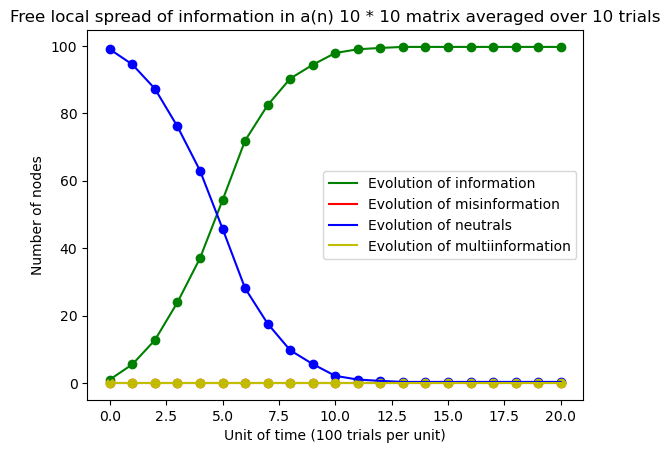

(11.3, 99.7, 0.0, 0.3, 0.0)

In [110]:
free_spread_multi_trial(10, 10, 10, 20)

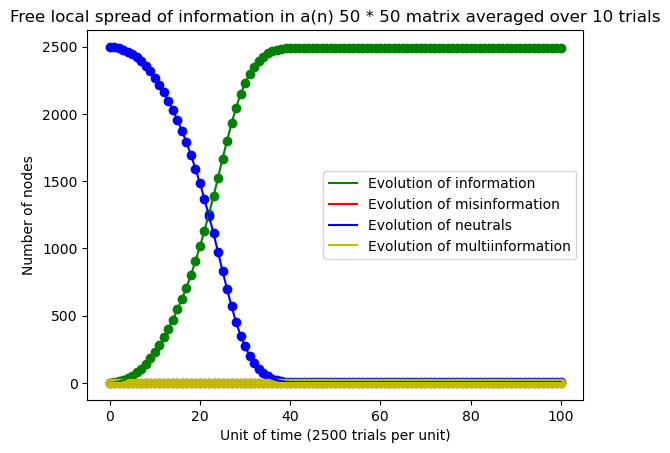

(39.4, 2494.1, 0.0, 5.9, 0.0)

In [112]:
free_spread_multi_trial(50, 50, 10, 100)

In [ ]:
def time_dependent_spread_multi_trial(N, M, trials, times, p=0.5, states=state_map, sources=source_map, age=False, graph=True):
    infos = np.zeros([times+1])
    misinfos = np.zeros([times+1])
    neutrals = np.zeros([times+1])
    multis = np.zeros([times+1])
    equilibrium = 0
    valid = 0
    
    for time in range(trials):
        grid = Grid(N, M)
        for source in sources:
            grid.config[source[0]][source[1]].change_state(source[2], grid)
        # grid.config[0][0].change_state('t', grid)
        # grid.config[N//2][M//2].change_state('f', grid)
        result = grid.multi_spread_graph(times, p, age, graph=False)
        info = result[1]
        misinfo = result[2]
        neutral = result[3]
        multi = result[4]
        while len(info) < times + 1:
            info = np.append(info, info[-1])
            misinfo = np.append(misinfo, misinfo[-1])
            neutral = np.append(neutral, neutral[-1])
            multi = np.append(multi, multi[-1])
        infos = infos + info
        misinfos = misinfos + misinfo
        neutrals = neutrals + neutral
        multis = multis + multi
        if result[5] != 0:
            valid = valid + 1
            equilibrium = equilibrium + result[5]

    infos = infos / trials
    misinfos = misinfos / trials
    neutrals = neutrals / trials
    multis = multis / trials
    equilibrium = equilibrium / valid

    if graph:
        fig, ax = plt.subplots()
        n = np.arange(times+1)
        ax.plot(n,infos,label= 'Evolution of information',color='g')
        ax.plot(n,misinfos,label= 'Evolution of misinformation',color='r')
        ax.plot(n,neutrals,label= 'Evolution of neutrals',color='b')
        ax.plot(n,multis,label= 'Evolution of multiinformation',color='y')
        ax.scatter(n,infos,color="g")
        ax.scatter(n,misinfos,color="r")
        ax.scatter(n,neutrals,color='b')
        ax.scatter(n,multis,color='y')
        ax.set_title("Time-dependent local spread of information in \n a(n) " + str(N) + " * " + str(M) + " matrix averaged over " + str(trials) + " trials")
        ax.set_ylabel('Number of nodes')
        ax.set_xlabel('Unit of time (1 trial on every node)')
    
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

    return equilibrium, infos[-1], misinfos[-1], neutrals[-1], multis[-1]

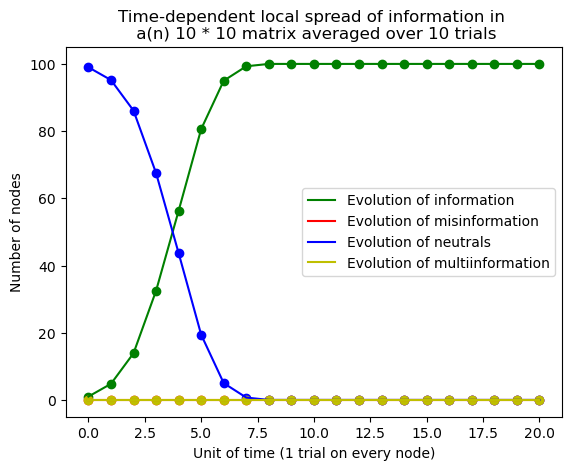

(7.4, 100.0, 0.0, 0.0, 0.0)

In [281]:
time_dependent_spread_multi_trial(10, 10, 10, 20)

## 7. Discussion and Conclusion

1. This model can simulate information propagation in scenarios similar to fixed 2D lattices and verify statistical predictions of when and how equilibrium is reached.
2. Enabling contact between far neighbors significantly speeds up propagation.
3. There is a critical 𝒑_𝟎 in whether equilibrium can be reached globally non-trivially for a certain 𝑎. For 𝑎=5, 𝑝_0≈0.2.
4. These apply to different grid sizes and initial source conditions.
5. Further consider the effects of the following:
* Global sources (announcements)
* Surprisal of misinformation [2], which may produce state-specific 𝑝
* Credulity: a reduced 𝑝 when exposed but not credulous
* Individual differences in 𝑝
* Fluidity in node motion


## 8. References

[1] Jenner, A.L., Aogo, R.A., Davis, C.L., Smith, A.M., Craig, M. Leveraging Computational Modeling to Understand Infectious Diseases. Curr Pathobiol Rep 8, 149–161 (2020). <br>
[2] https://en.wikipedia.org/wiki/Information_content <br>
[3] This project is the final project of the course PHYS 25000 taught by Professor David Miller at the University of Chicago in Autumn 2024: https://github.com/ UChicagoPhysics/PHYS250/tree/master. In particular, the material on Ising model is extensively cited. <br>
[4] matplotlib resources:
* Annotate: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
* Arrow: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.arrow.html
* Scatter plot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter